In [1]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
import collections
import scipy.signal
import functools
from IPython.display import HTML, display
from tqdm import tqdm
import sklearn.metrics
import hdbscan
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

                
seed_number_range = []     
for num in range(2,3):
    seed_number_range.append(f'Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0,5,10,15,20,25,50,100,800,1000,1100,1200,1300,1400,1500]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}



Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

WARNING    <timed exec>:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 29.8 s, sys: 9.42 s, total: 39.3 s
Wall time: 47 s


# Figure S4 - A,B,C

In [2]:
%%time
t_start = 1 * second
t_stop = 59 * second
bin_size = 1 * second
coupling = '_Coupled'

colors = dict(positive='#1c4981',negative='#8a1218')
cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)

names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'
        

data = []
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','DCN','IO']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(['after_Plasticity']):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)


CPU times: user 108 ms, sys: 24.1 ms, total: 132 ms
Wall time: 457 ms


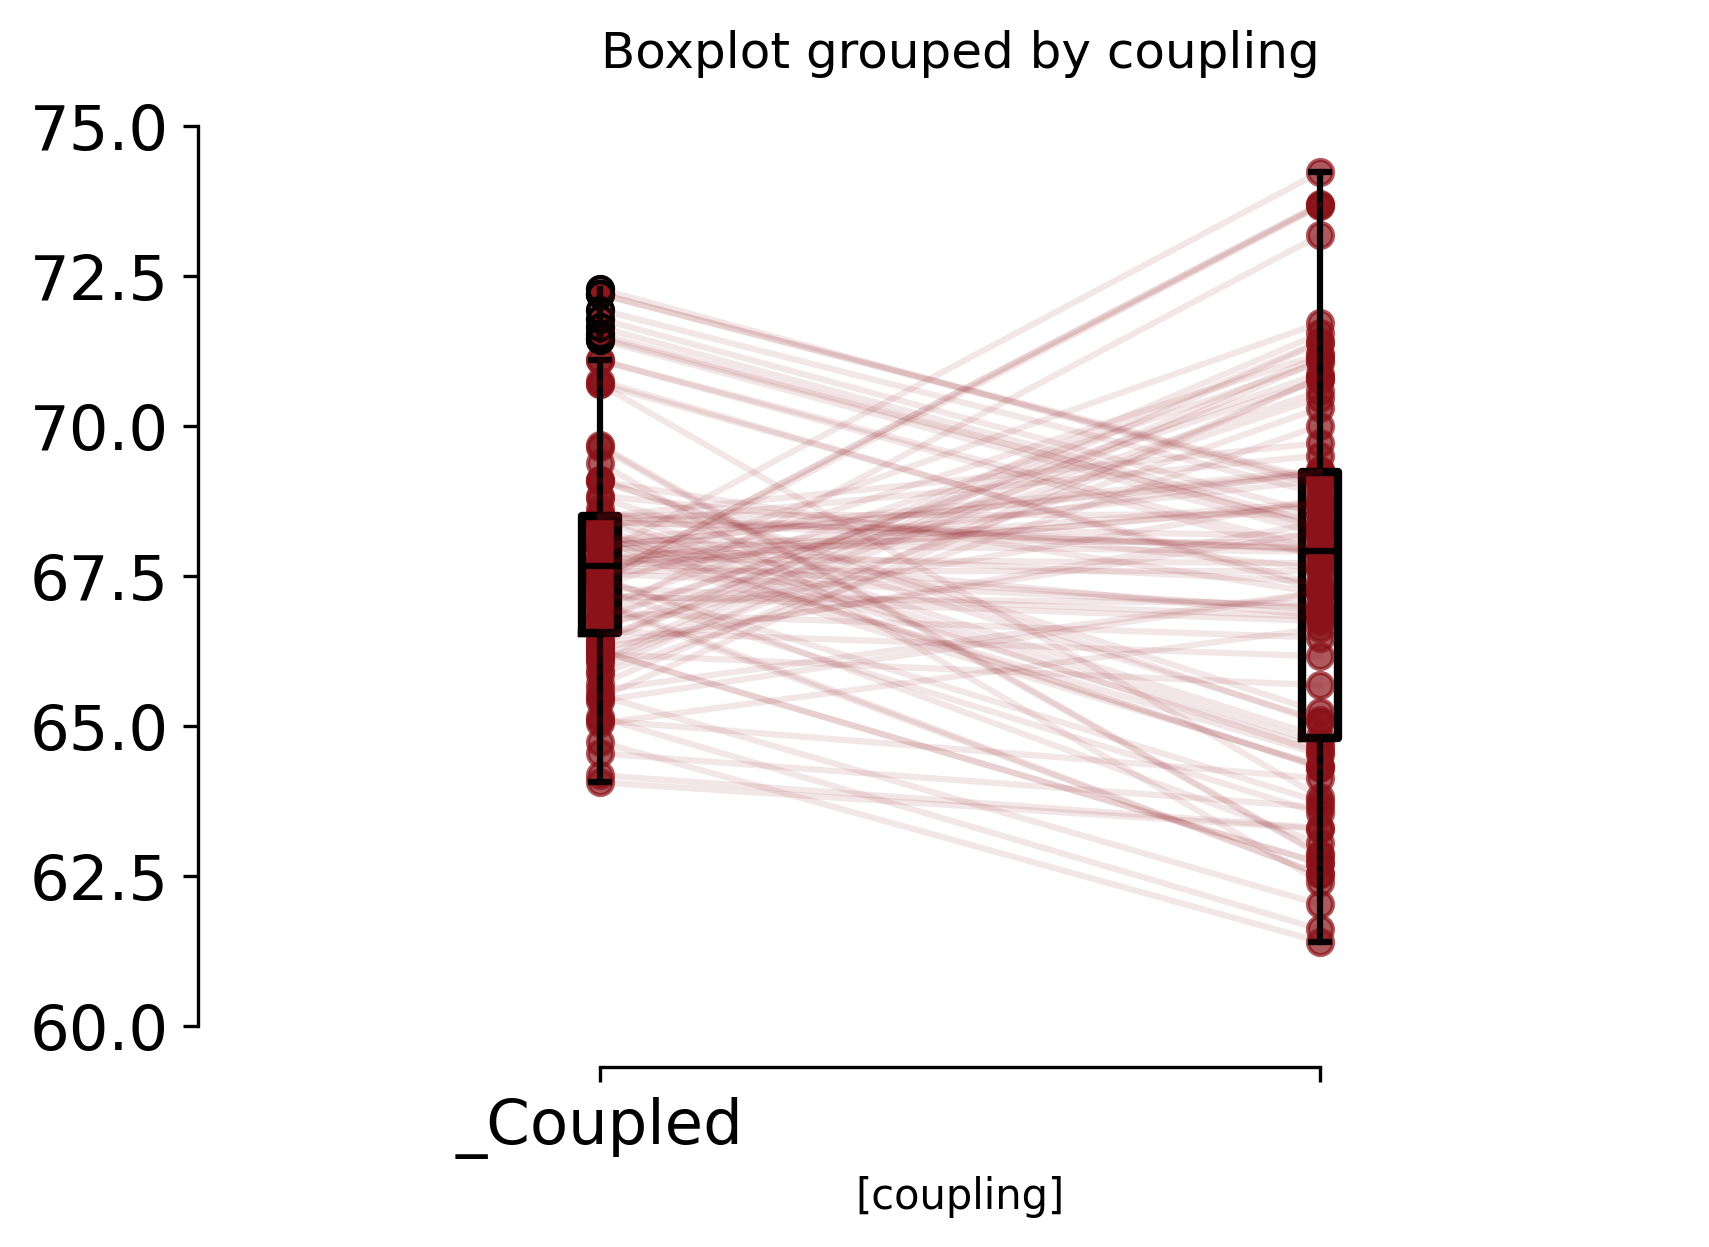

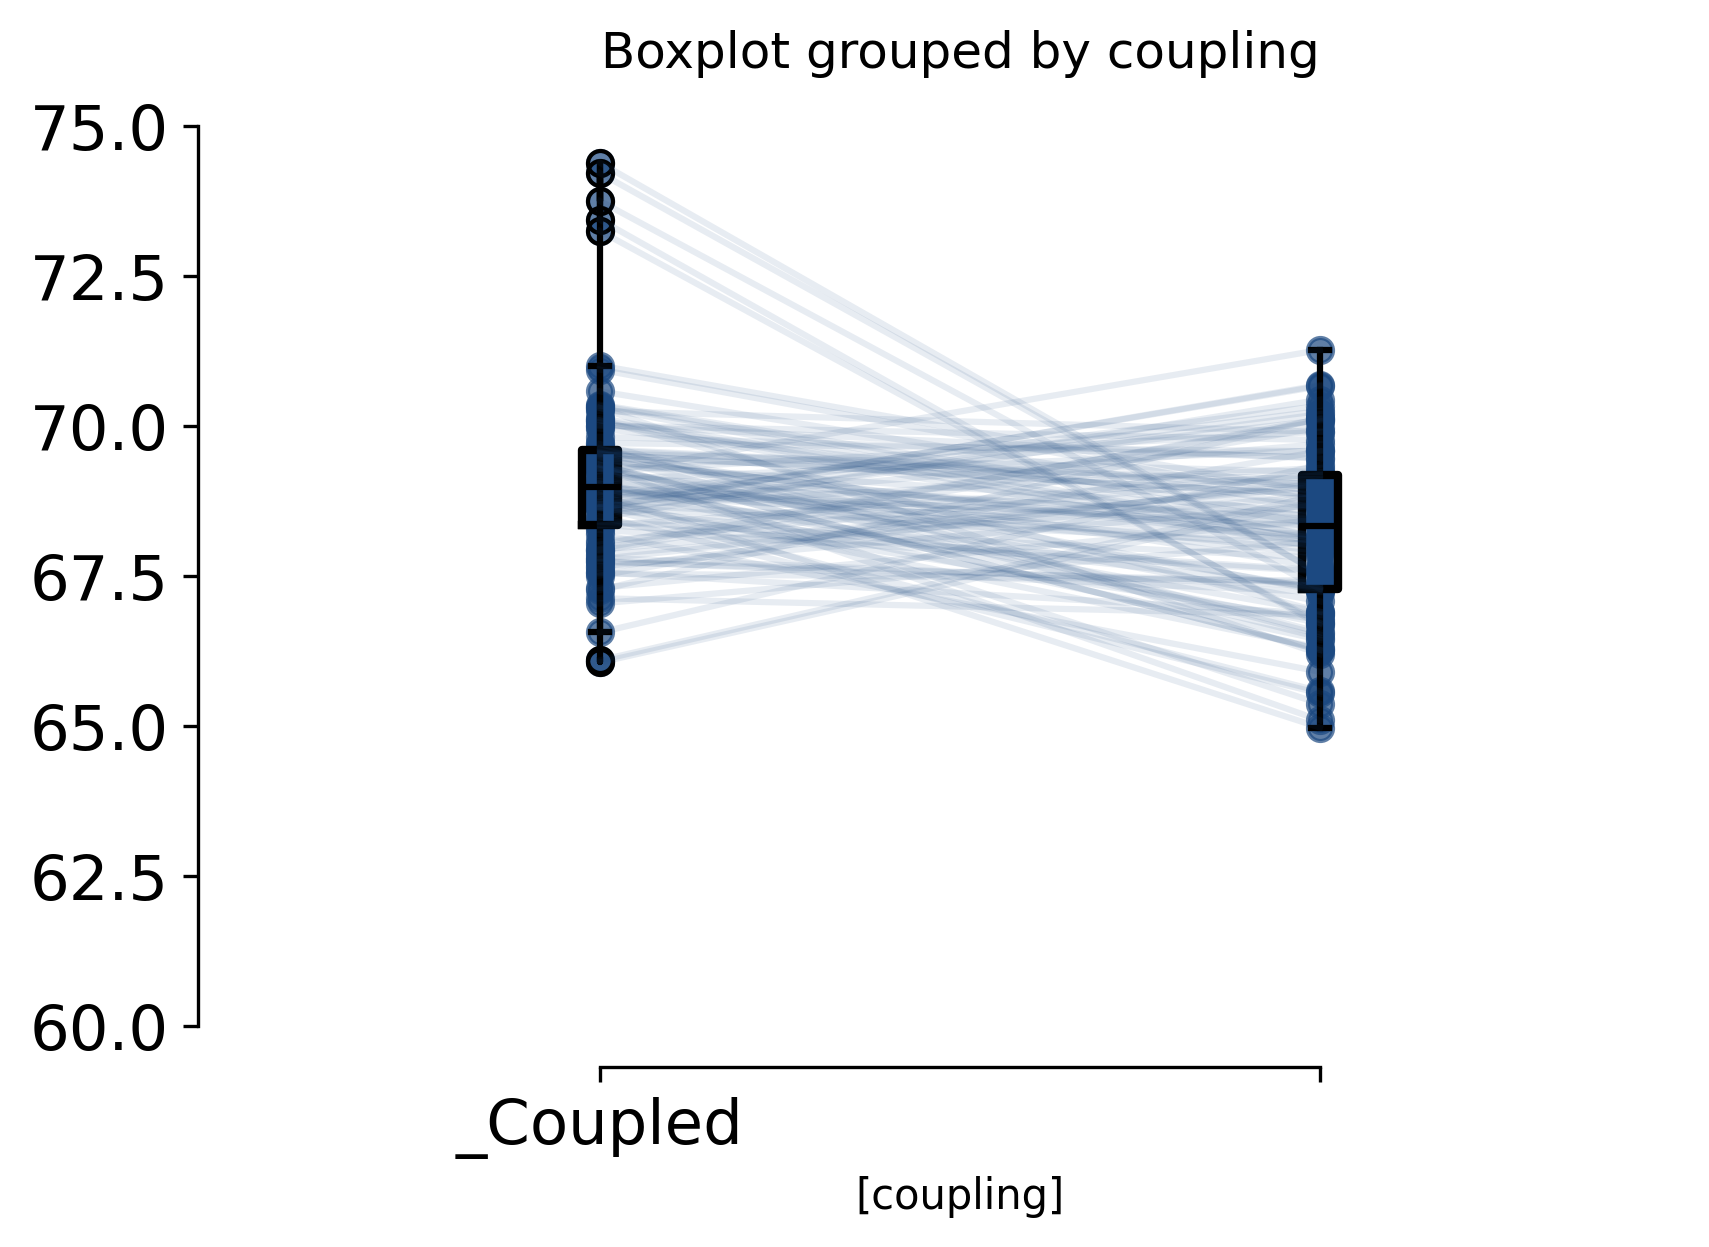

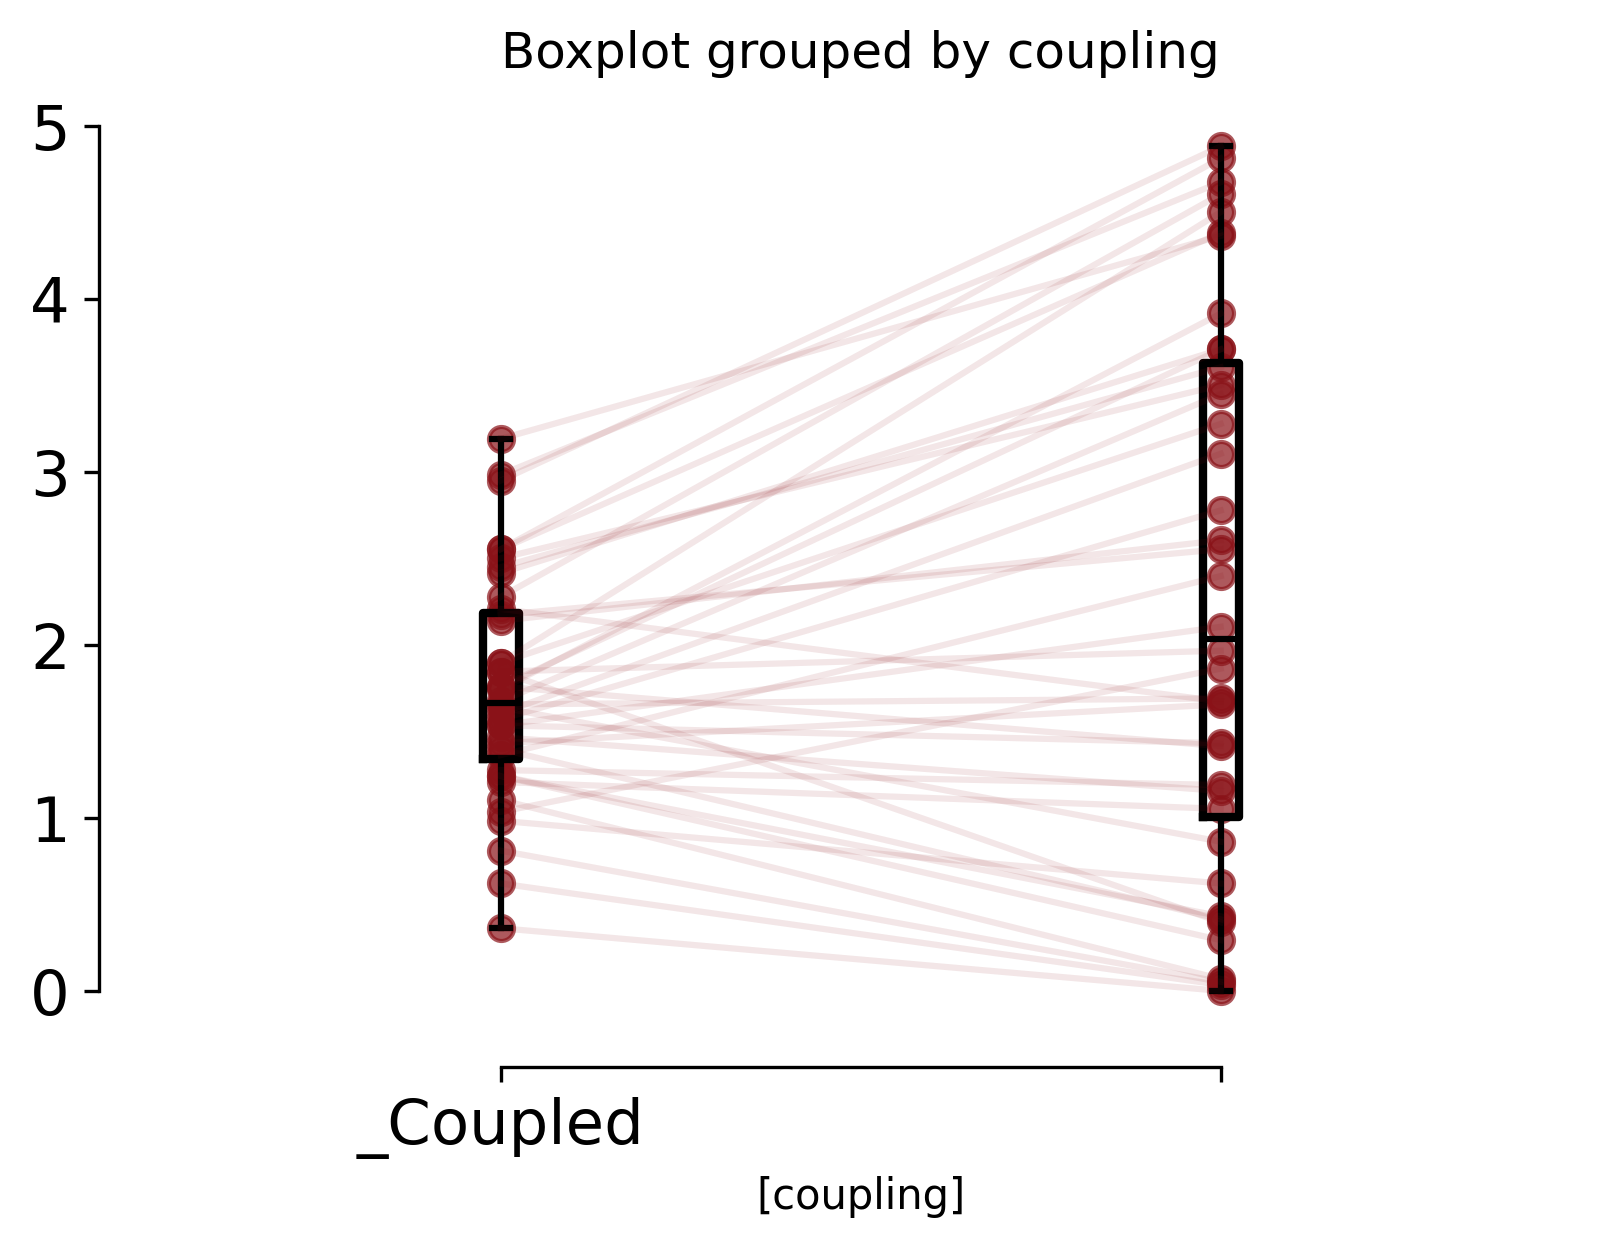

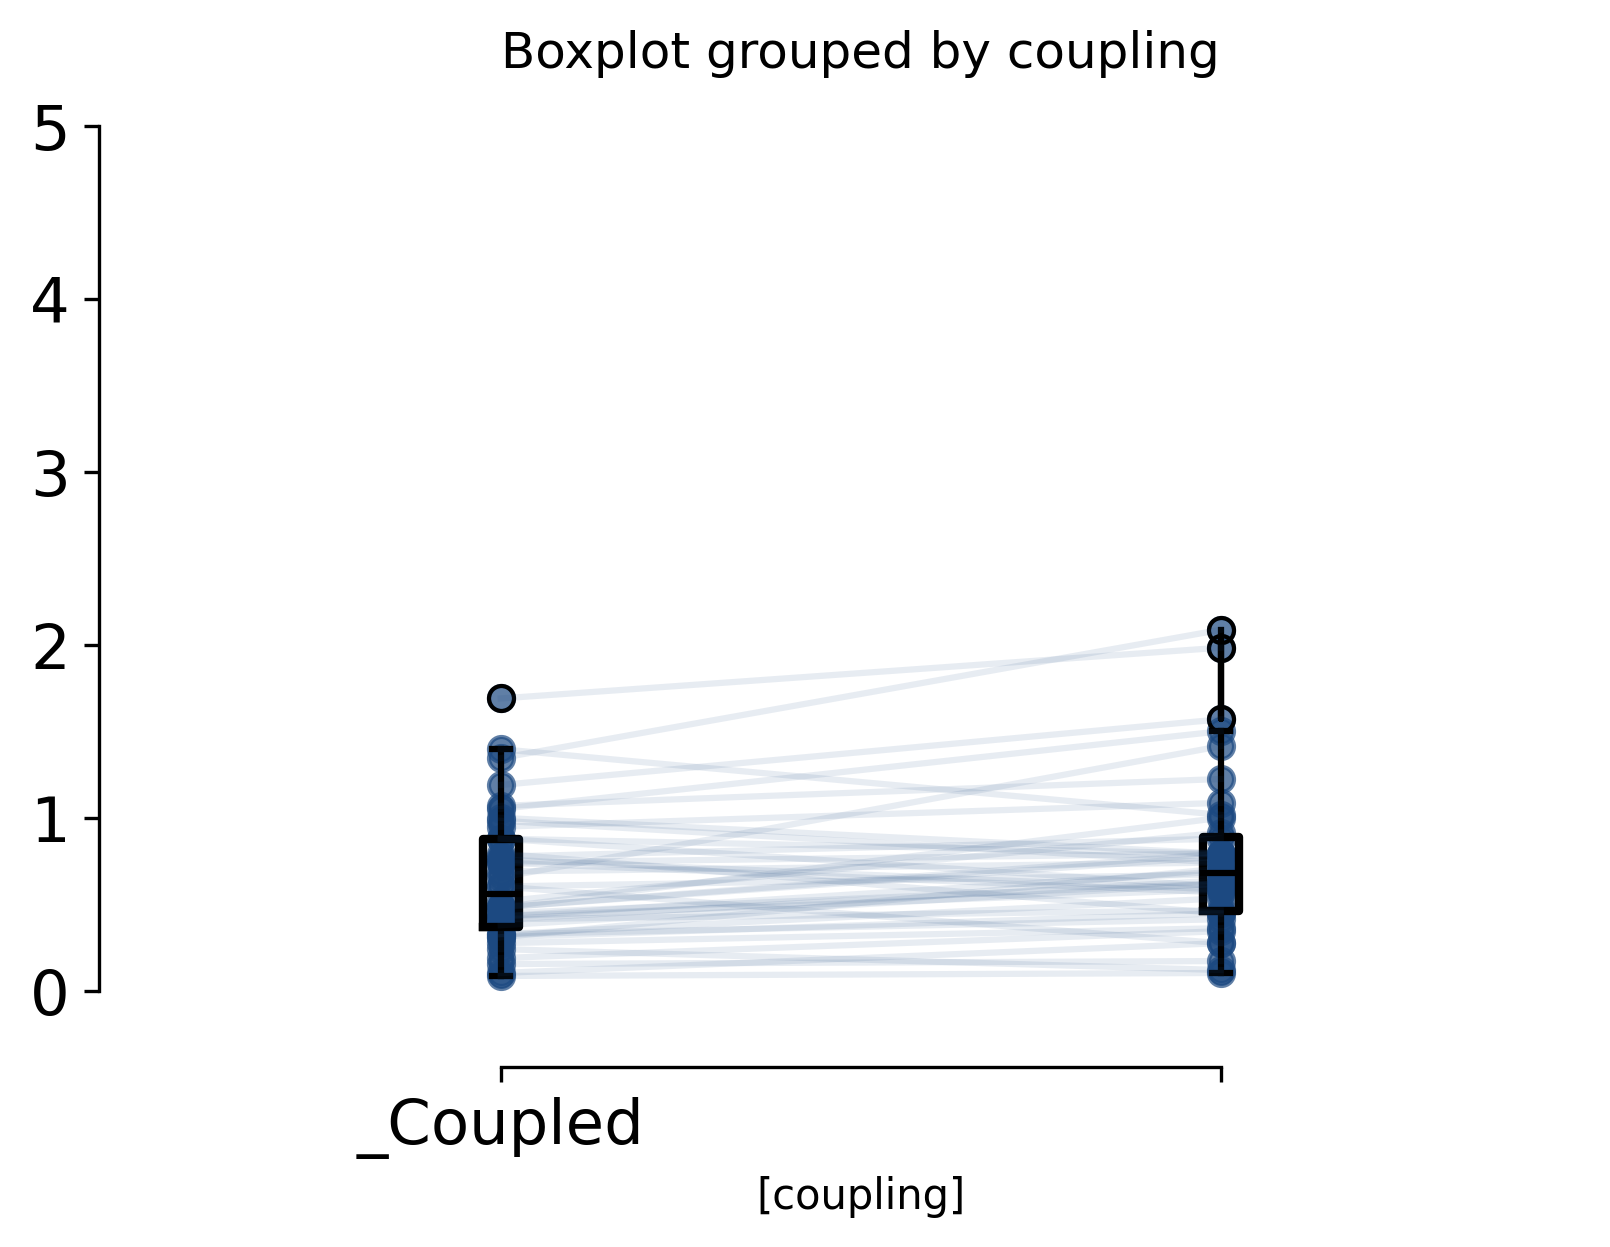

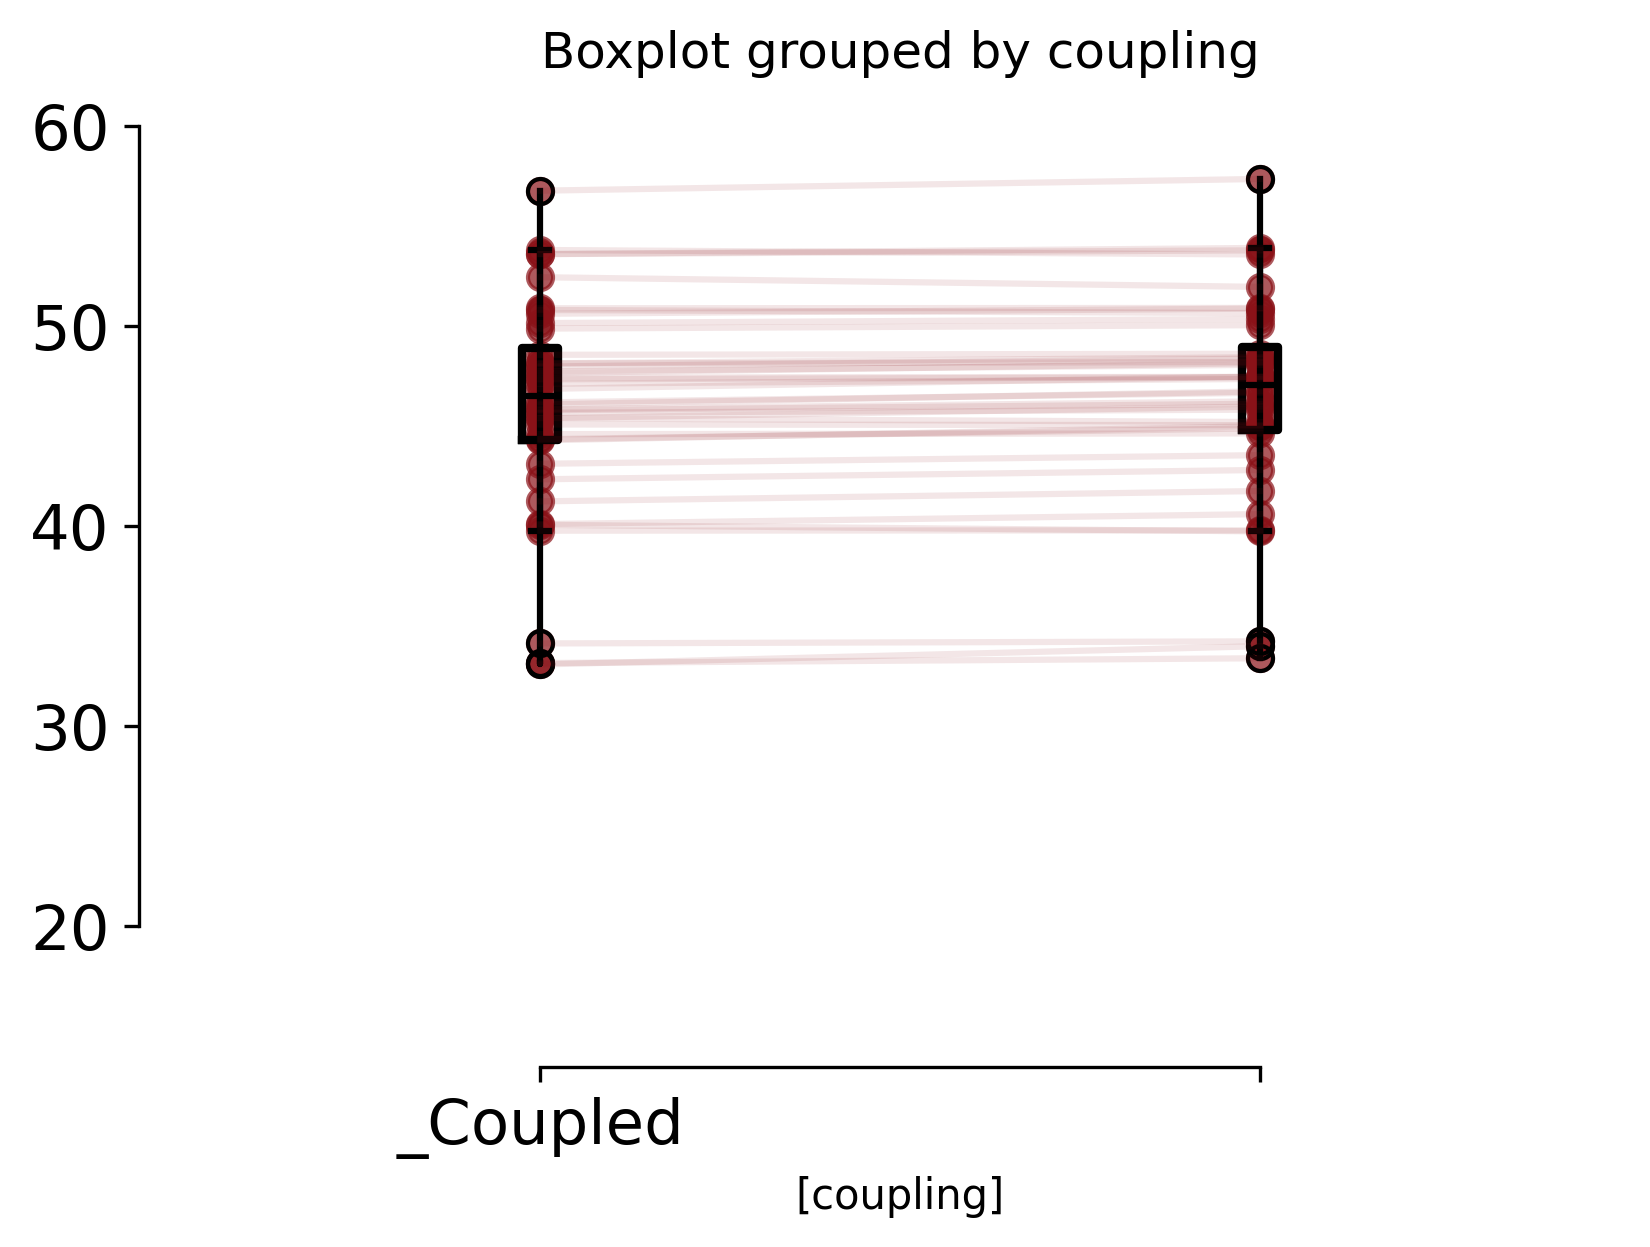

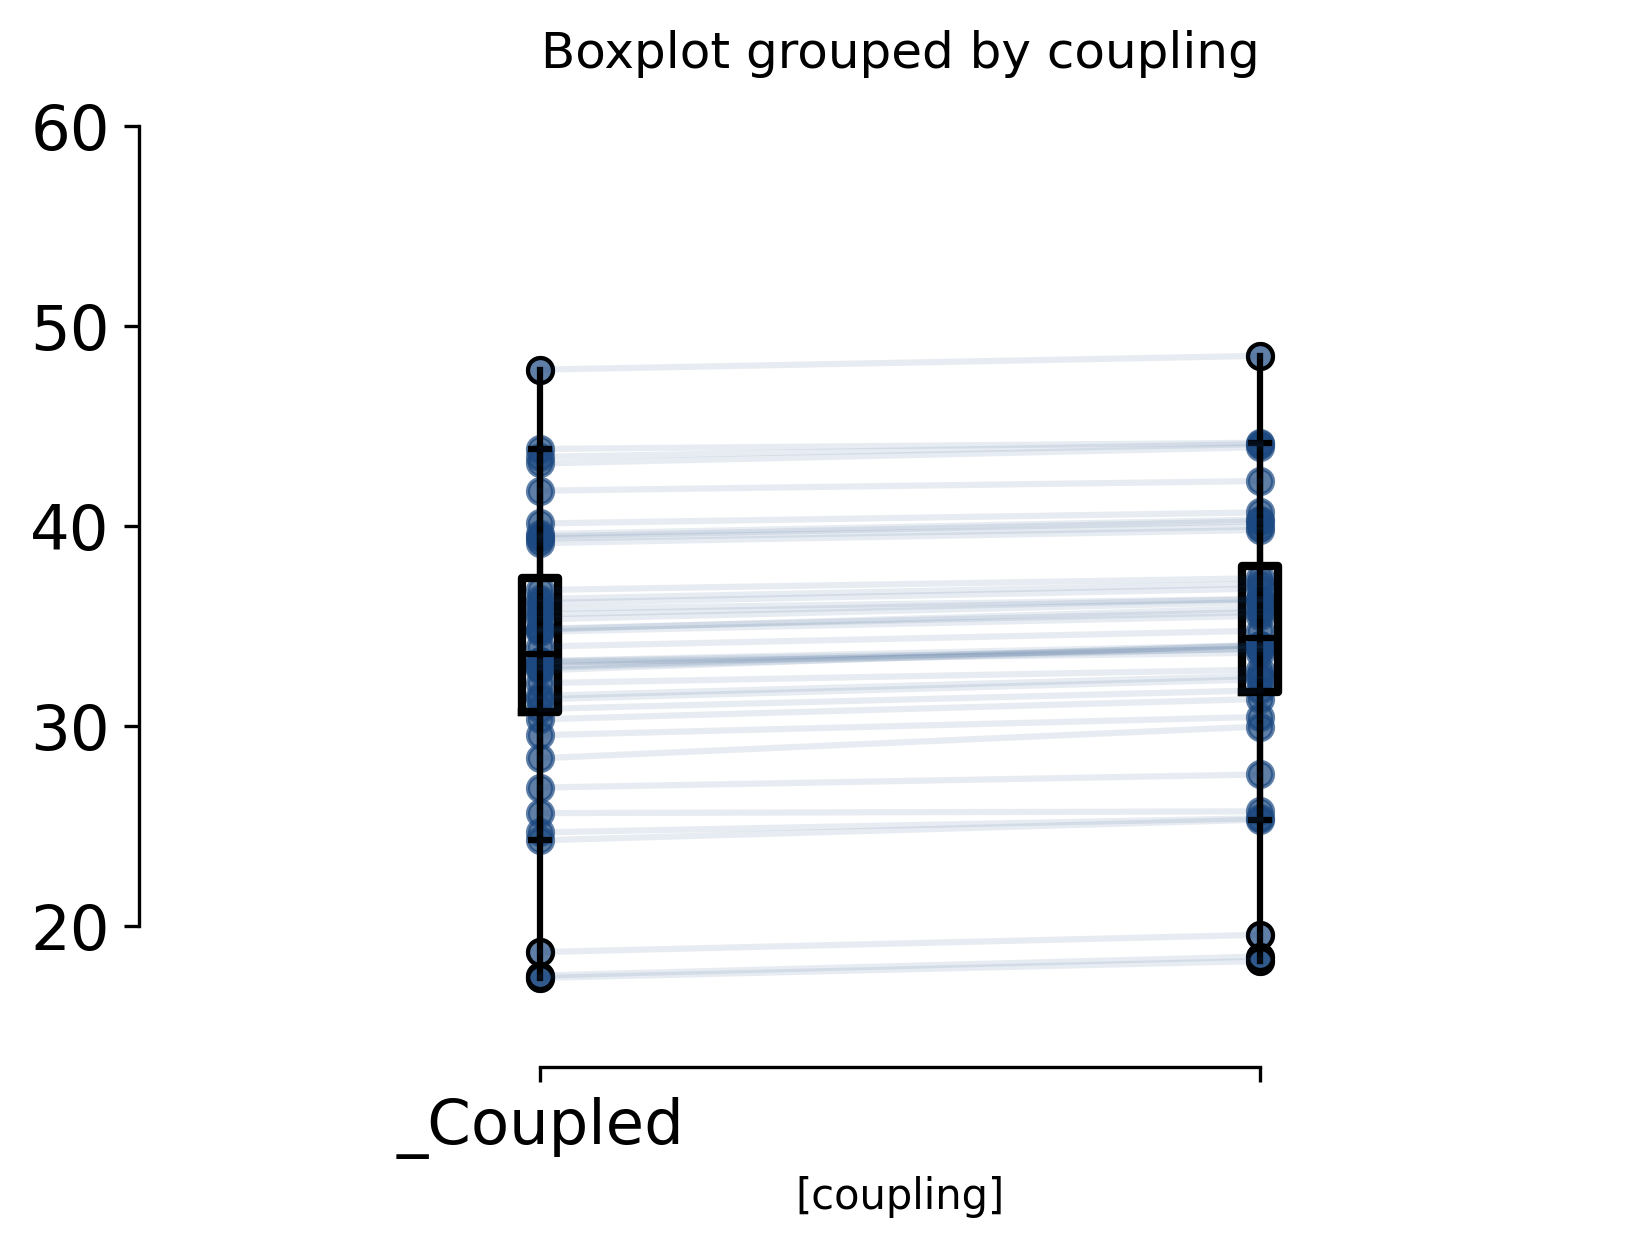

In [3]:
var = 'frequency'
plasticity = 'after_Plasticity'
x = {}
y = {}
for cell_name in ['PC','IO','DCN']:
    x[cell_name] = {}
    y[cell_name] = {}
    for zebrin in ['negative','positive']:
        df_data = df_ff[(df_ff["plasticity"]==names[f'{plasticity}']) & (df_ff["cell"]==cell_name) & (df_ff["zebrin"]==zebrin)]
        Q1, Q3 = percentile(df_data[var],[5,95])
        IQR = Q3 - Q1    #IQR is interquartile range. 
        lower_boundary = Q1 - 1.5 * IQR
        upper_boundary = Q3 + 1.5 * IQR
        df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
        fig = plt.figure(dpi=300)
        flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
        bp = df_data2.boxplot(column=var, by=['coupling'], grid=False, figsize=(4,3), widths=0.05, fontsize=15,
                             color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                             boxprops=dict(linestyle='-', linewidth=2),
                             flierprops=dict(linestyle='-', linewidth=1.5),
                             medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                             whiskerprops=dict(linestyle='-', linewidth=1.5),
                             capprops=dict(linestyle='-', linewidth=1.5),
                         positions=[2,1],ax = plt.gca())      
        title(f'')#title(f'CF Pauses {plasticity}{coupling}')
#         colors = dict(positive='b',negative='r')
        x[cell_name][zebrin] = {}
        y[cell_name][zebrin] = {}
        for i,coupling in enumerate(['_Coupled','']):
            y[cell_name][zebrin][f'{coupling}'] = df_data2.frequency[(df_data2.zebrin==zebrin) & (df_data2.coupling==coupling)].dropna()
            x[cell_name][zebrin][f'{coupling}'] = [1+i]*len(y[cell_name][zebrin][f'{coupling}'])#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
            scatter(x[cell_name][zebrin][f'{coupling}'], y[cell_name][zebrin][f'{coupling}'],color=f'{colors[zebrin]}', alpha=0.7)
        toPlot = zip(x[cell_name][zebrin]['_Coupled'], y[cell_name][zebrin]['_Coupled'], x[cell_name][zebrin][''], y[cell_name][zebrin][''])
        for tuple in toPlot:
            plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.1)
        xticks([1,2],['_Coupled',''])
        if cell_name == 'PC':
            ylim([60,75])
        elif cell_name == 'IO':
            ylim([-0.2,5])
        elif cell_name == 'DCN':
            ylim([15,60])
    #     yticks(np.arange(20, 80+1, 20))
    #         axis('off')
    #         plt.ylabel("FF [Hz]")
#         plt.savefig(f'{cell_name}_{var}_boxplot_{zebrin}.svg')
        sns.despine(trim=True,offset = 10)
        plt.show()

## Statistics across zebrin

In [5]:
from prettytable import PrettyTable
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, f


# Function to format p-values
def format_p_value(p):
    return "<0.001" if p < 0.001 else round(p, 3)

# Function to create a table for a specific cell_name
def create_table(cell_name, y):
    table = PrettyTable(["Test", "Upbound", "Downbound"])
    table.align = "l"  # Left-align columns

    # Prepare placeholders for results
    results = {
        "Mann-Whitney U stat": [None, None],
        "Mann-Whitney U p": [None, None],
        "F-test stat": [None, None],
        "F-test p": [None, None],
        "t-test stat": [None, None],
        "t-test p": [None, None],
    }

    # Loop through Zebrin types
    for i, zebrin in enumerate(['positive', 'negative']):
        # Calculate Mann-Whitney U test
        U1, p_mw = mannwhitneyu(
            y[cell_name][zebrin]['_Coupled'],
            y[cell_name][zebrin][''],
            method="exact"
        )

        # Calculate F-test for variance
        variance1 = np.var(y[cell_name][zebrin]['_Coupled'], ddof=1)
        variance2 = np.var(y[cell_name][zebrin][''], ddof=1)
        f_value = variance1 / variance2
        df1 = len(y[cell_name][zebrin]['_Coupled']) - 1
        df2 = len(y[cell_name][zebrin]['']) - 1
        p_f = f.sf(f_value, df1, df2)

        # Calculate t-test for means
        t_stat, p_t = ttest_ind(
            y[cell_name][zebrin]['_Coupled'],
            y[cell_name][zebrin]['']
        )

        # Save results in the correct column
        results["Mann-Whitney U stat"][i] = round(U1, 2)
        results["Mann-Whitney U p"][i] = format_p_value(p_mw)
        results["F-test stat"][i] = round(f_value, 2)
        results["F-test p"][i] = format_p_value(p_f)
        results["t-test stat"][i] = round(t_stat, 2)
        results["t-test p"][i] = format_p_value(p_t)

    # Add results to the table
    for test_name, values in results.items():
        table.add_row([test_name] + values)

    return table

# Create and print tables for each cell_name
for cell_name in ['PC', 'IO', 'DCN']:
    print(f"Coupling Comparison Results for {cell_name}:")
    print(create_table(cell_name, y))
    print("\n")

Coupling Comparison Results for PC:
+---------------------+---------+-----------+
| Test                | Upbound | Downbound |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 6608.5  | 5146.5    |
| Mann-Whitney U p    | <0.001  | 0.723     |
| F-test stat         | 1.11    | 0.39      |
| F-test p            | 0.3     | 1.0       |
| t-test stat         | 4.51    | 1.02      |
| t-test p            | <0.001  | 0.31      |
+---------------------+---------+-----------+


Coupling Comparison Results for IO:
+---------------------+---------+-----------+
| Test                | Upbound | Downbound |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 676.0   | 667.0     |
| Mann-Whitney U p    | 0.236   | 0.204     |
| F-test stat         | 0.69    | 0.16      |
| F-test p            | 0.878   | 1.0       |
| t-test stat         | -1.28   | -1.97     |
| t-test p            | 0.204   | 0.052     |
+---------------------+---------+-----------+


Coup

## Statistics across coupling

In [6]:
from prettytable import PrettyTable
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, f

# Function to format p-values
def format_p_value(p):
    return "<0.001" if p < 0.001 else round(p, 3)

# Function to create a table for zebrin comparison
def create_zebrin_comparison_table(cell_name, y):
    table = PrettyTable(["Test", "Coupled", "Uncoupled"])  # Columns for no_coupling (NP) and after_coupling (AP)
    table.align = "l"  # Left-align columns

    # Prepare placeholders for results
    results = {
        "Mann-Whitney U stat": [None, None],
        "Mann-Whitney U p": [None, None],
        "F-test stat": [None, None],
        "F-test p": [None, None],
        "t-test stat": [None, None],
        "t-test p": [None, None],
    }

    # Loop through coupling conditions
    for i, coupling in enumerate(['_Coupled', '']):
        # Calculate Mann-Whitney U test
        U1, p_mw = mannwhitneyu(
            y[cell_name]['negative'][coupling],
            y[cell_name]['positive'][coupling],
            method="exact"
        )

        # Calculate F-test for variance
        variance1 = np.var(y[cell_name]['negative'][coupling], ddof=1)
        variance2 = np.var(y[cell_name]['positive'][coupling], ddof=1)
        f_value = variance1 / variance2
        df1 = len(y[cell_name]['negative'][coupling]) - 1
        df2 = len(y[cell_name]['positive'][coupling]) - 1
        p_f = f.sf(f_value, df1, df2)

        # Calculate t-test for means
        t_stat, p_t = ttest_ind(
            y[cell_name]['negative'][coupling],
            y[cell_name]['positive'][coupling]
        )

        # Save results in the correct column
        results["Mann-Whitney U stat"][i] = round(U1, 2)
        results["Mann-Whitney U p"][i] = format_p_value(p_mw)
        results["F-test stat"][i] = round(f_value, 2)
        results["F-test p"][i] = format_p_value(p_f)
        results["t-test stat"][i] = round(t_stat, 2)
        results["t-test p"][i] = format_p_value(p_t)

    # Add results to the table
    for test_name, values in results.items():
        table.add_row([test_name] + values)

    return table


# Create and print tables for each cell_name
for cell_name in ['PC', 'IO', 'DCN']:
    print(f"Zebrin Comparison Results for {cell_name}:")
    print(create_zebrin_comparison_table(cell_name, y))
    print("\n")

Zebrin Comparison Results for PC:
+---------------------+---------+-----------+
| Test                | Coupled | Uncoupled |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 2566.5  | 4291.0    |
| Mann-Whitney U p    | <0.001  | 0.083     |
| F-test stat         | 1.69    | 4.85      |
| F-test p            | 0.005   | <0.001    |
| t-test stat         | -5.36   | -2.22     |
| t-test p            | <0.001  | 0.028     |
+---------------------+---------+-----------+


Zebrin Comparison Results for IO:
+---------------------+---------+-----------+
| Test                | Coupled | Uncoupled |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 1499.0  | 1236.0    |
| Mann-Whitney U p    | <0.001  | <0.001    |
| F-test stat         | 2.91    | 12.19     |
| F-test p            | <0.001  | <0.001    |
| t-test stat         | 9.44    | 5.84      |
| t-test p            | <0.001  | <0.001    |
+---------------------+---------+-----------+


Zebrin C

# Figure S4 - D

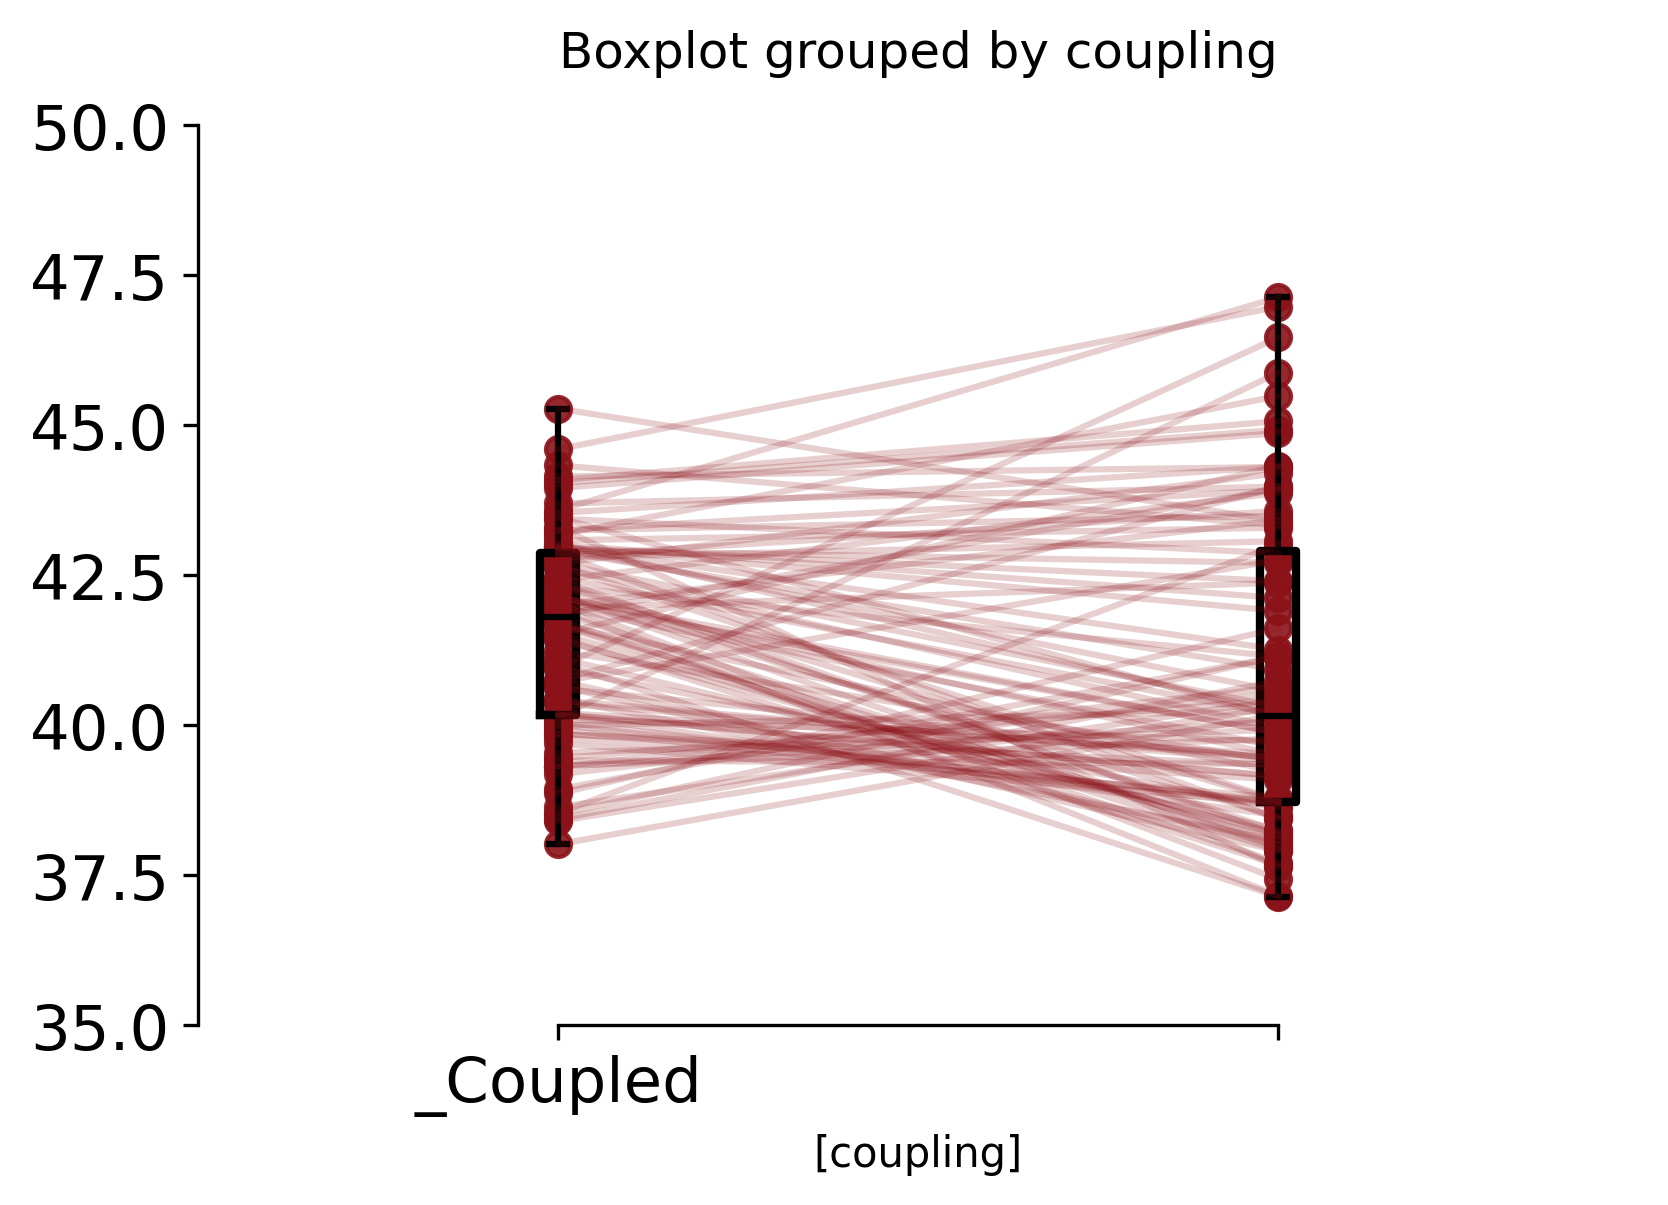

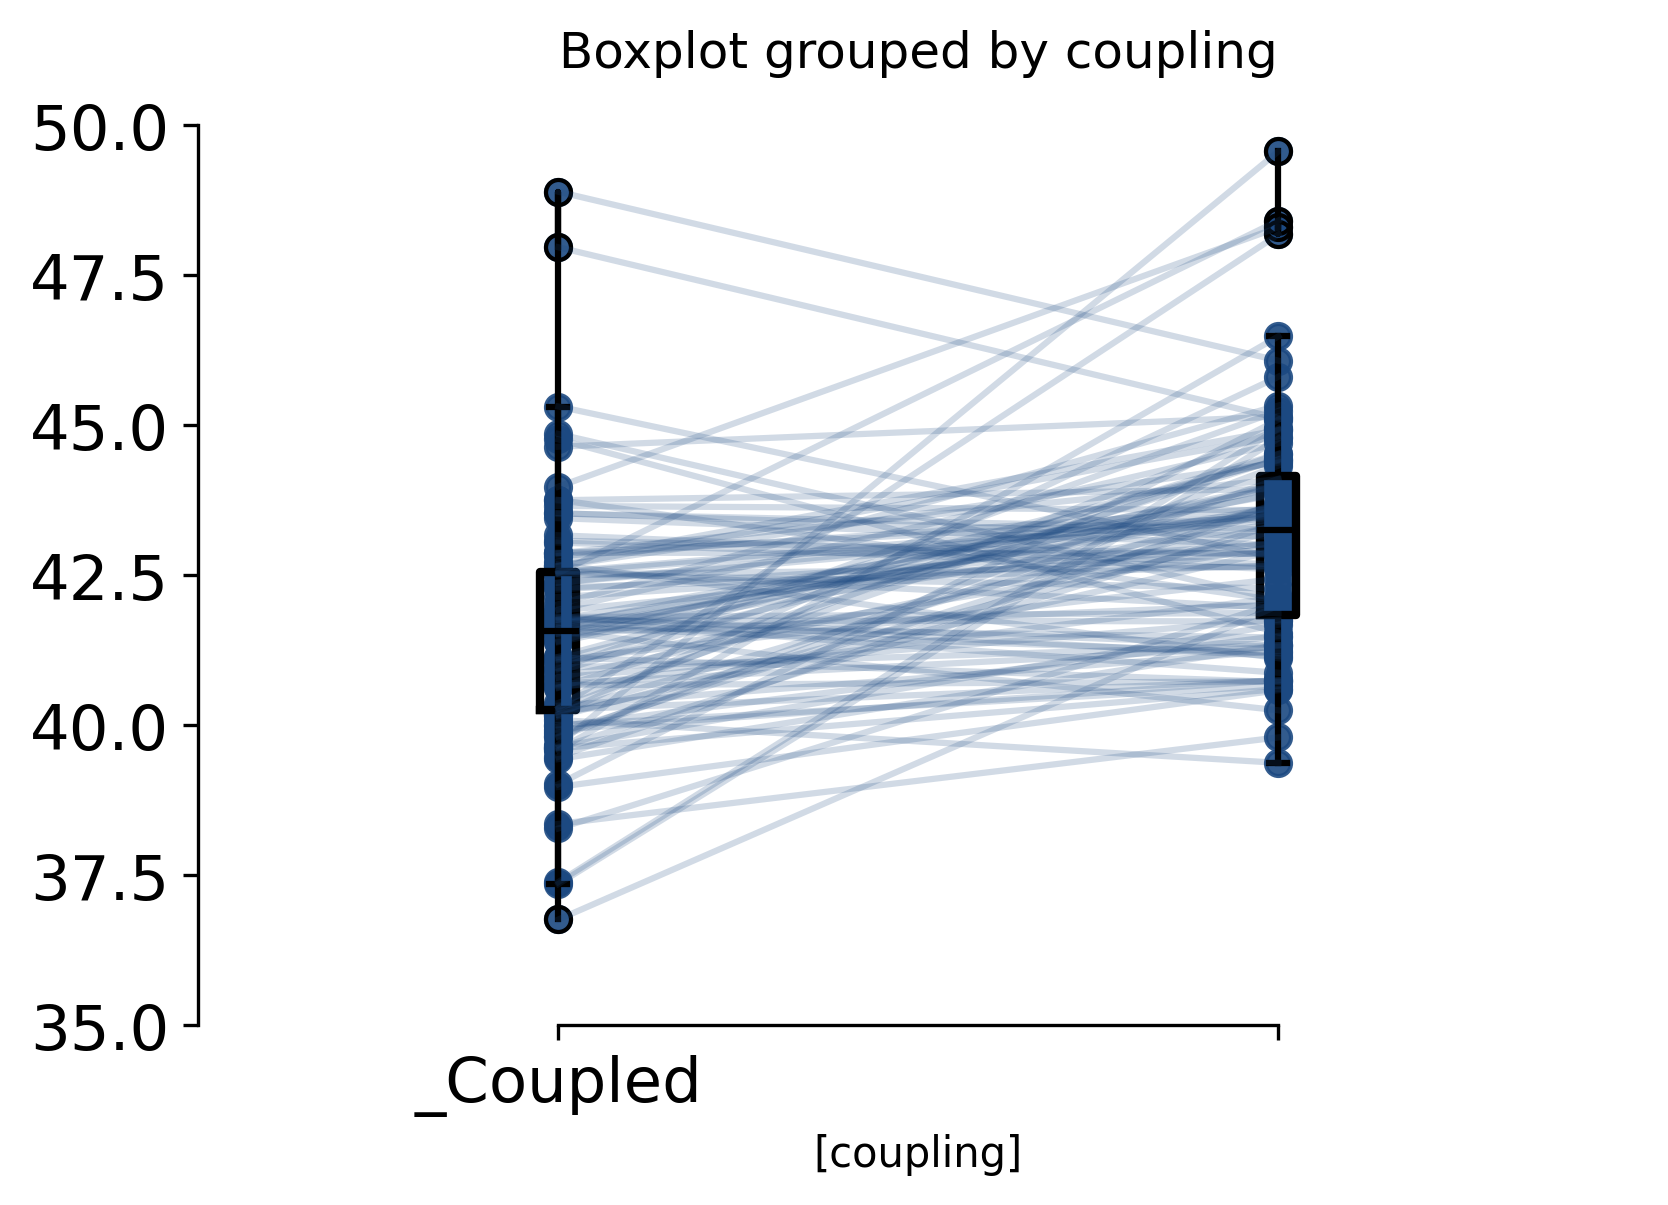

CPU times: user 34.8 s, sys: 251 ms, total: 35.1 s
Wall time: 35.1 s


In [10]:
%%time 

skip = 5*ms/second # seconds
transient_time = 10000
data = []
# 
for zebrin in zebrin_range:
    zeb_name = 'Z+'
    if zebrin == 'negative': zeb_name = 'Z-'
    for coupling in coupling_range:
        coup_name = 'Coup'
        if coupling == '': coup_name = 'Uncoup'
        for plasticity in ['after_Plasticity']:
            plas_name = 'NP'
            if plasticity == 'Plasticity': plas_name = 'P'
            elif plasticity == 'after_Plasticity': plas_name = 'AP'
            IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources
            IO_Spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            PC_Spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            for pc_cell_id in range(N_Cells_PC):
                pauses = []
                io_cell_id = IO_num_con[pc_cell_id]
                row = dict(PC=pc_cell_id)
                row['IO'] = io_cell_id
                for io_spike in IO_Spikes[f'{io_cell_id}']:
                    if io_spike < transient_time*ms/second: continue
                    hit = None
                    for pc_spike in PC_Spikes[f'{pc_cell_id}']:
                        if pc_spike <= io_spike+skip:
                            continue
                        hit = pc_spike
                        break
                    if hit is not None:
                        pauses.append((hit - io_spike))
                pauses = np.array(pauses)*1e3
                row['average_pause'] = mean(pauses)
                row['zebrin'] = zebrin
                row['plasticity'] = plasticity
                row['coupling'] = coupling
                data.append(row)
                
df_pauses = pd.DataFrame(data).dropna()
colors = dict(positive='#1c4981',negative='#8a1218')

var = 'average_pause'
plasticity = 'after_Plasticity'
x = {}
y = {}
for zebrin in ['negative','positive']:
    df_data = df_pauses[(df_pauses["plasticity"]==plasticity)&(df_pauses["zebrin"]==zebrin)]
    Q1, Q3 = percentile(df_data[var],[5,95])
    IQR = Q3 - Q1    #IQR is interquartile range. 
    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR
    df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
    fig = plt.figure(dpi=300)
    flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
    bp = df_data2.boxplot(column=var, by=['coupling'], grid=False, figsize=(4,3), widths=0.05, fontsize=15,
                         color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                         boxprops=dict(linestyle='-', linewidth=2),
                         flierprops=dict(linestyle='-', linewidth=1.5),
                         medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                         whiskerprops=dict(linestyle='-', linewidth=1.5),
                         capprops=dict(linestyle='-', linewidth=1.5),
                         positions=[2,1],ax = plt.gca()) 
    title(f'')#title(f'CF Pauses {plasticity}{coupling}')
    colors = dict(positive='#1c4981',negative='#8a1218')
    y[zebrin] = {}
    x[zebrin] = {}
    for i,coupling in enumerate(['_Coupled','']):
        y[zebrin][f'{coupling}'] = df_data2.average_pause[(df_data2.coupling==coupling)].dropna()
        x[zebrin][f'{coupling}'] = [1+i]*len(y[zebrin][f'{coupling}'])
        scatter(x[zebrin][f'{coupling}'], y[zebrin][f'{coupling}'],color=f'{colors[zebrin]}', alpha=0.9)
    toPlot = zip(x[zebrin]['_Coupled'], y[zebrin]['_Coupled'], x[zebrin][''], y[zebrin][''])
    for tuple in toPlot:
        plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'{colors[zebrin]}',alpha=0.2)
    xticks([1,2],['_Coupled',''])
    ylim([35,50])
#     yticks(np.arange(20, 80+1, 20))
#         axis('off')
#         plt.ylabel("FF [Hz]")
    sns.despine(trim=True)
#     plt.savefig(f'CF_{var}_boxplot_{zebrin}.svg')
    plt.show()

## Statistics across coupling

In [11]:
from prettytable import PrettyTable
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, f


# Function to format p-values
def format_p_value(p):
    return "<0.001" if p < 0.001 else round(p, 3)

# Function to create a table for a specific cell_name
def create_table(y):
    table = PrettyTable(["Test", "Upbound", "Downbound"])
    table.align = "l"  # Left-align columns

    # Prepare placeholders for results
    results = {
        "Mann-Whitney U stat": [None, None],
        "Mann-Whitney U p": [None, None],
        "F-test stat": [None, None],
        "F-test p": [None, None],
        "t-test stat": [None, None],
        "t-test p": [None, None],
    }

    # Loop through Zebrin types
    for i, zebrin in enumerate(['positive', 'negative']):
        # Calculate Mann-Whitney U test
        U1, p_mw = mannwhitneyu(
            y[zebrin]['_Coupled'],
            y[zebrin][''],
            method="exact"
        )

        # Calculate F-test for variance
        variance1 = np.var(y[zebrin]['_Coupled'], ddof=1)
        variance2 = np.var(y[zebrin][''], ddof=1)
        f_value = variance1 / variance2
        df1 = len(y[zebrin]['_Coupled']) - 1
        df2 = len(y[zebrin]['']) - 1
        p_f = f.sf(f_value, df1, df2)

        # Calculate t-test for means
        t_stat, p_t = ttest_ind(
            y[zebrin]['_Coupled'],
            y[zebrin]['']
        )

        # Save results in the correct column
        results["Mann-Whitney U stat"][i] = round(U1, 2)
        results["Mann-Whitney U p"][i] = format_p_value(p_mw)
        results["F-test stat"][i] = round(f_value, 2)
        results["F-test p"][i] = format_p_value(p_f)
        results["t-test stat"][i] = round(t_stat, 2)
        results["t-test p"][i] = format_p_value(p_t)

    # Add results to the table
    for test_name, values in results.items():
        table.add_row([test_name] + values)

    return table

# Create and print tables for each cell_name

print(f"Plasticity Comparison Results for CF Pause:")
print(create_table(y))
print("\n")

Plasticity Comparison Results for CF Pause:
+---------------------+---------+-----------+
| Test                | Upbound | Downbound |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 2480.0  | 6214.0    |
| Mann-Whitney U p    | <0.001  | 0.003     |
| F-test stat         | 1.05    | 0.44      |
| F-test p            | 0.406   | 1.0       |
| t-test stat         | -6.25   | 2.5       |
| t-test p            | <0.001  | 0.013     |
+---------------------+---------+-----------+




## Statistics across zebrin

In [12]:
from prettytable import PrettyTable
import numpy as np
from scipy.stats import mannwhitneyu, ttest_ind, f

# Function to format p-values
def format_p_value(p):
    return "<0.001" if p < 0.001 else round(p, 3)

# Function to create a table for zebrin comparison
def create_zebrin_comparison_table(y):
    table = PrettyTable(["Test", "Coupled", "Uncoupled"])  # Columns for no_Plasticity (NP) and after_Plasticity (AP)
    table.align = "l"  # Left-align columns

    # Prepare placeholders for results
    results = {
        "Mann-Whitney U stat": [None, None],
        "Mann-Whitney U p": [None, None],
        "F-test stat": [None, None],
        "F-test p": [None, None],
        "t-test stat": [None, None],
        "t-test p": [None, None],
    }

    # Loop through plasticity conditions
    for i, plasticity in enumerate(['_Coupled', '']):
        # Calculate Mann-Whitney U test
        U1, p_mw = mannwhitneyu(
            y['negative'][plasticity],
            y['positive'][plasticity],
            method="exact"
        )

        # Calculate F-test for variance
        variance1 = np.var(y['negative'][plasticity], ddof=1)
        variance2 = np.var(y['positive'][plasticity], ddof=1)
        f_value = variance1 / variance2
        df1 = len(y['negative'][plasticity]) - 1
        df2 = len(y['positive'][plasticity]) - 1
        p_f = f.sf(f_value, df1, df2)

        # Calculate t-test for means
        t_stat, p_t = ttest_ind(
            y['negative'][plasticity],
            y['positive'][plasticity]
        )

        # Save results in the correct column
        results["Mann-Whitney U stat"][i] = round(U1, 2)
        results["Mann-Whitney U p"][i] = format_p_value(p_mw)
        results["F-test stat"][i] = round(f_value, 2)
        results["F-test p"][i] = format_p_value(p_f)
        results["t-test stat"][i] = round(t_stat, 2)
        results["t-test p"][i] = format_p_value(p_t)

    # Add results to the table
    for test_name, values in results.items():
        table.add_row([test_name] + values)

    return table


# Create and print tables for each cell_name
print(f"Zebrin Comparison Results for CF Pause:")
print(create_zebrin_comparison_table(y))
print("\n")

Zebrin Comparison Results for CF Pause:
+---------------------+---------+-----------+
| Test                | Coupled | Uncoupled |
+---------------------+---------+-----------+
| Mann-Whitney U stat | 5175.0  | 2192.0    |
| Mann-Whitney U p    | 0.67    | <0.001    |
| F-test stat         | 0.76    | 1.82      |
| F-test p            | 0.917   | 0.002     |
| t-test stat         | -0.02   | -7.76     |
| t-test p            | 0.984   | <0.001    |
+---------------------+---------+-----------+




# Figure S4 - E

In [5]:
class Case(collections.abc.Mapping):
    def __init__(self, **kw):
        self.kw = kw
        for k in kw:
            assert k in ['coupling', 'zebrin', 'plasticity']
    def __len__(self):
        return 1
    def __getitem__(self, k):
        return self.kw[k]
    def __iter__(self):
        return iter(self.kw)
    def __eq__(self, other):
        for k in ['coupling', 'zebrin', 'plasticity']:
            if self.kw.get(k, '*') !=  other.kw.get(k, '*'):
                return False
        return True
    def __hash__(self):
        return __builtins__.sum(hash(f'{k}{self.kw.get(k, "*")}') for k in ['coupling', 'zebrin', 'plasticity'])
    @property
    def before(self):
        kw = dict(self.kw)
        kw['plasticity'] = False
        return Case(**kw)
    @property
    def after(self):
        kw = dict(self.kw)
        kw['plasticity'] = True
        return Case(**kw)
    @property
    def during(self):
        kw = dict(self.kw)
        kw['plasticity'] = None
        return Case(**kw)
    def __repr__(self):
        return '/'.join([
            {True: 'C', False: 'U', '*': '*'}[self.kw.get('coupling', '*')],
            {True: 'Z+', False: 'Z-', '*': '*'}[self.kw.get('zebrin', '*')],
            {True: 'AP', False: 'NP', None: 'P', '*': '*'}[self.kw.get('plasticity', '*')]])
@functools.lru_cache
def load_io_vs(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    IO_output = output_load_run('IO',
                                '_Coupled' if coupling else '',seed_number,
                                p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)
    return np.array(IO_output['Vs']/mV)
@functools.lru_cache
def load_io_spikes(coupling=True, plasticity=True, zebrin=True, n=0, f0=0, noise_gain=1):
    if plasticity is None:
        p = 'Plasticity'
    elif plasticity:
        p = 'after_Plasticity'
    else:
        p = 'no_Plasticity'
    if n > 1:
        p = f'{p}{n}'
    o = output_load_run('IO_spikes','_Coupled' if coupling else '',seed_number,
                           p,['negative', 'positive'][zebrin],noise_gain,exp_run,net_name,path_data,parameters_value,f0)

    x = []
    for i in range(N_Cells_IO):
        x.append(o[str(i)])
    return x

def get_cs_freq(case, f0, n):
    cs = load_io_spikes(**case, n=n, f0=f0, noise_gain=1)
    return np.array(list(map(len, cs))) / 120
def get_sto_freq(case, f0, n):
    'taken as mean of 2nd and 3rd quartile of 1/ hilbert phase period'
    v = np.array(load_io_vs(**case, n=n, f0=f0, noise_gain=1))
    v = calc_phase(v)
    v = np.diff((v > 0).astype(int)) == 1
    def sub(x):
        x = np.sort(x)
        return x[len(x)//4:-len(x)//4]
    return np.array([np.mean(sub(1000/np.diff(np.where(vv)[0]))) for vv in v])

def calc_synchrony(vs, fs=1000, order=5, lp=8, hp=15, lpsync=5):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.exp(1j*np.angle(analytic))
    synchrony = abs(angle.mean(0))
    sos = scipy.signal.butter(order, lpsync, 'lp', fs=fs, output='sos')
    return scipy.signal.sosfiltfilt(sos, synchrony)

def calc_phase(vs, fs=1000, order=5, lp=4, hp=15):
    'Ncells x Ntimesteps -> Ntimesteps'
    # synchrony changing faster than 5Hz doens't make sense for 10Hz STO's
    sos = scipy.signal.butter(order, (lp, hp), 'bp', fs=fs, output='sos')
    filt = scipy.signal.sosfiltfilt(sos, vs)
    analytic = scipy.signal.hilbert(filt - filt.mean())
    angle = np.angle(analytic)
    return angle
dcn_to_io = [[] for _ in range(40)]
io_to_dcn = [[] for _ in range(40)]
src = Synaps['Seed_'+str(seed_number)].DCN_IO_Synapse_Sources
tgt = Synaps['Seed_'+str(seed_number)].DCN_IO_Synapse_Targets
for a, b in zip(src, tgt):
    dcn_to_io[a].append(b)
    io_to_dcn[b].append(a)
dcn_to_io = [np.array(x) for x in dcn_to_io]
io_to_dcn = [np.array(x) for x in io_to_dcn]

CP = Case(coupling=True, zebrin=True)
CN = Case(coupling=True, zebrin=False)
UP = Case(coupling=False, zebrin=True)
UN = Case(coupling=False, zebrin=False)

CPU times: user 1.31 s, sys: 628 ms, total: 1.93 s
Wall time: 1.42 s


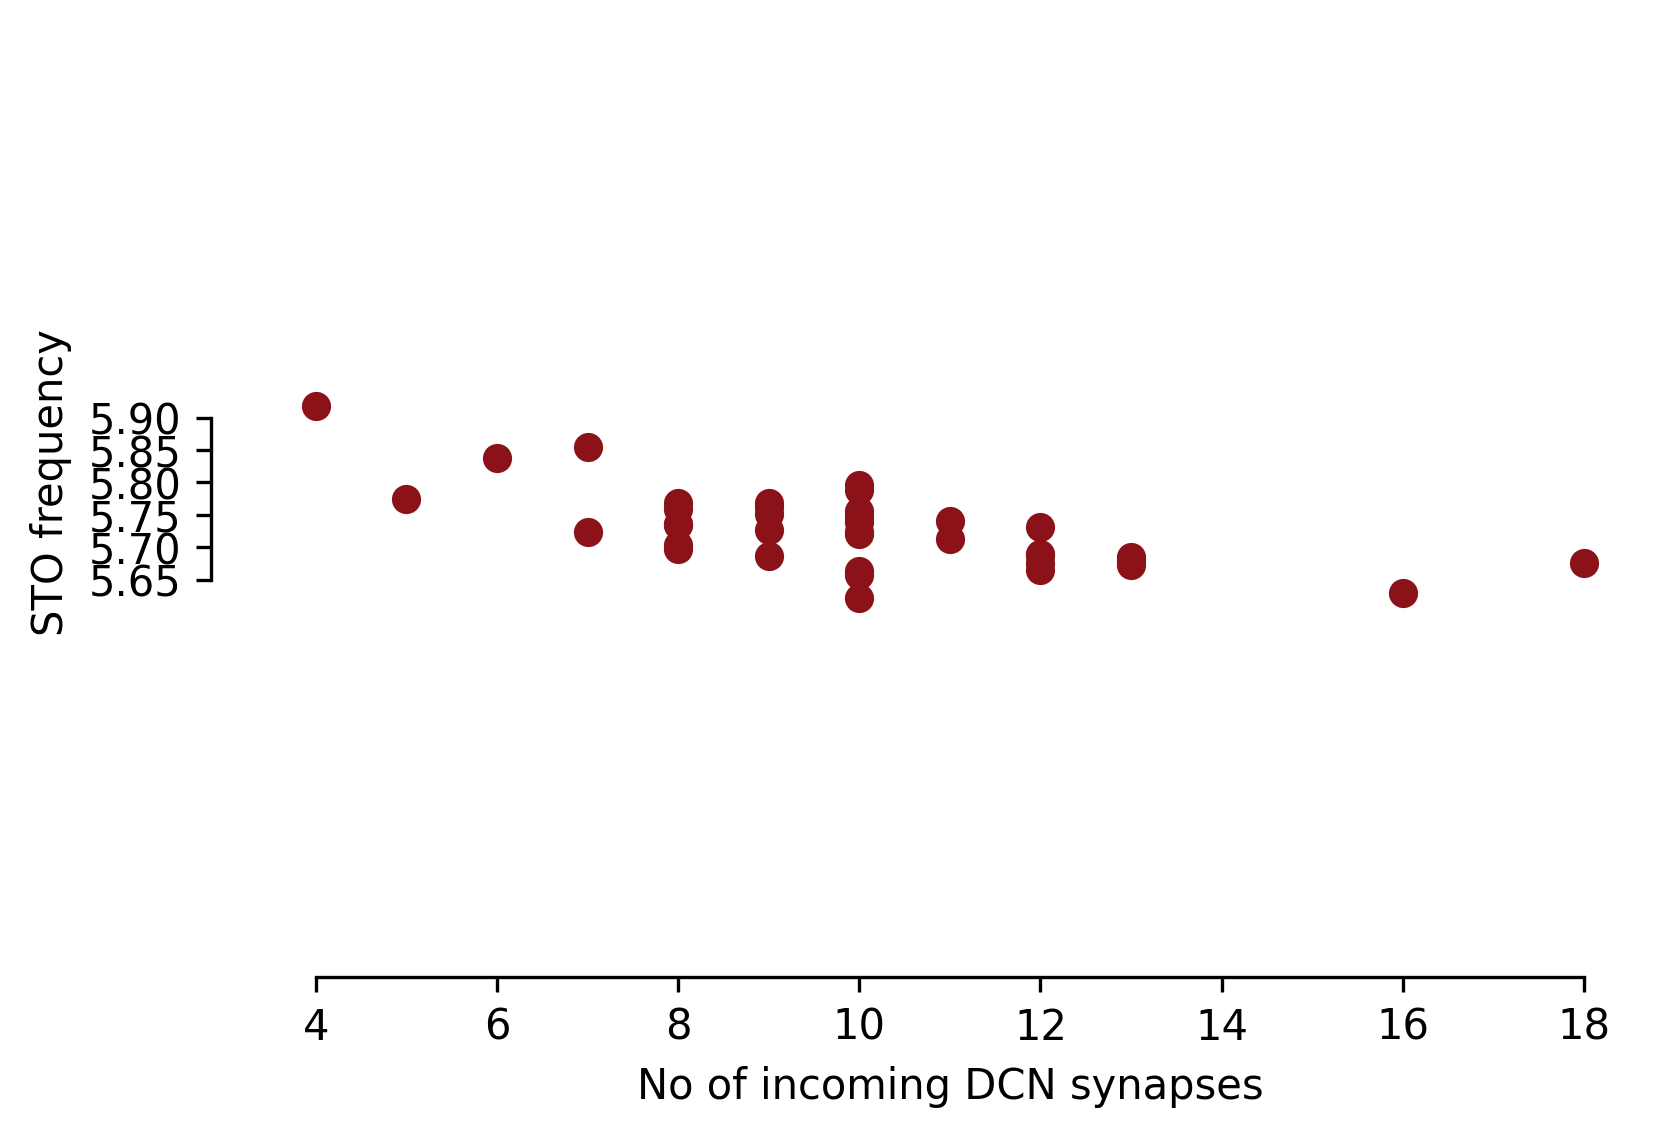

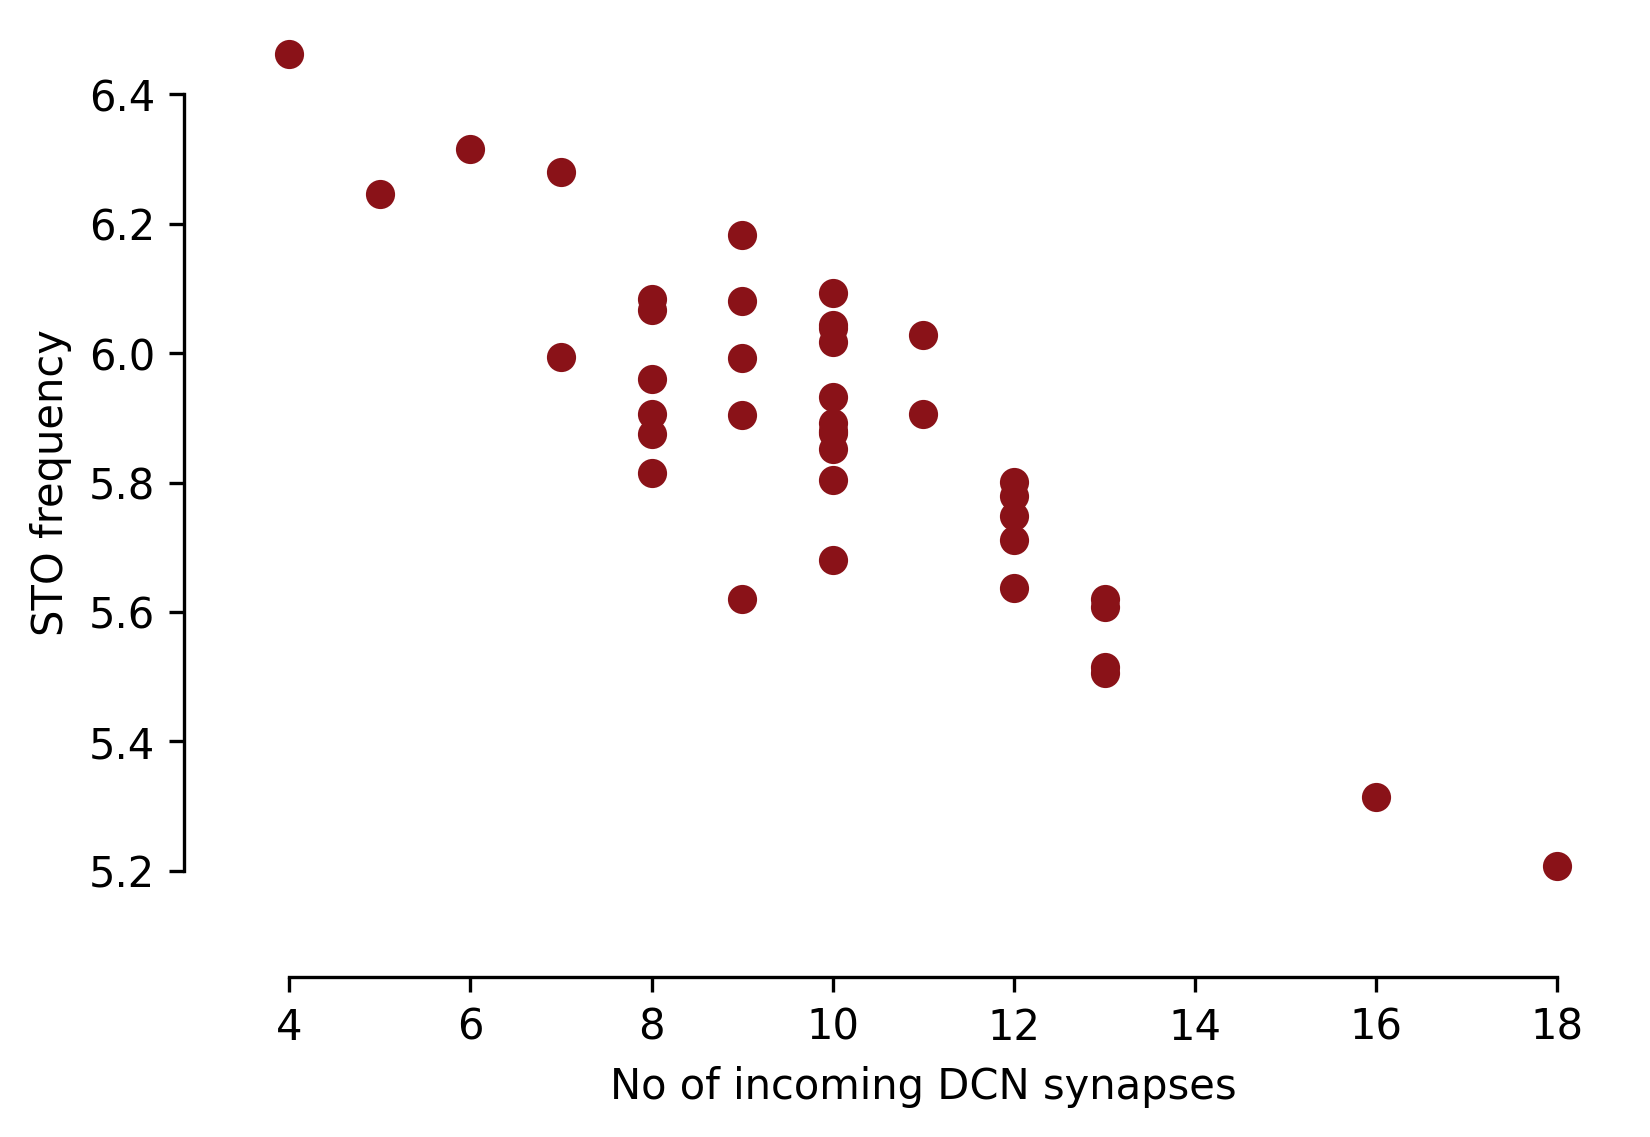

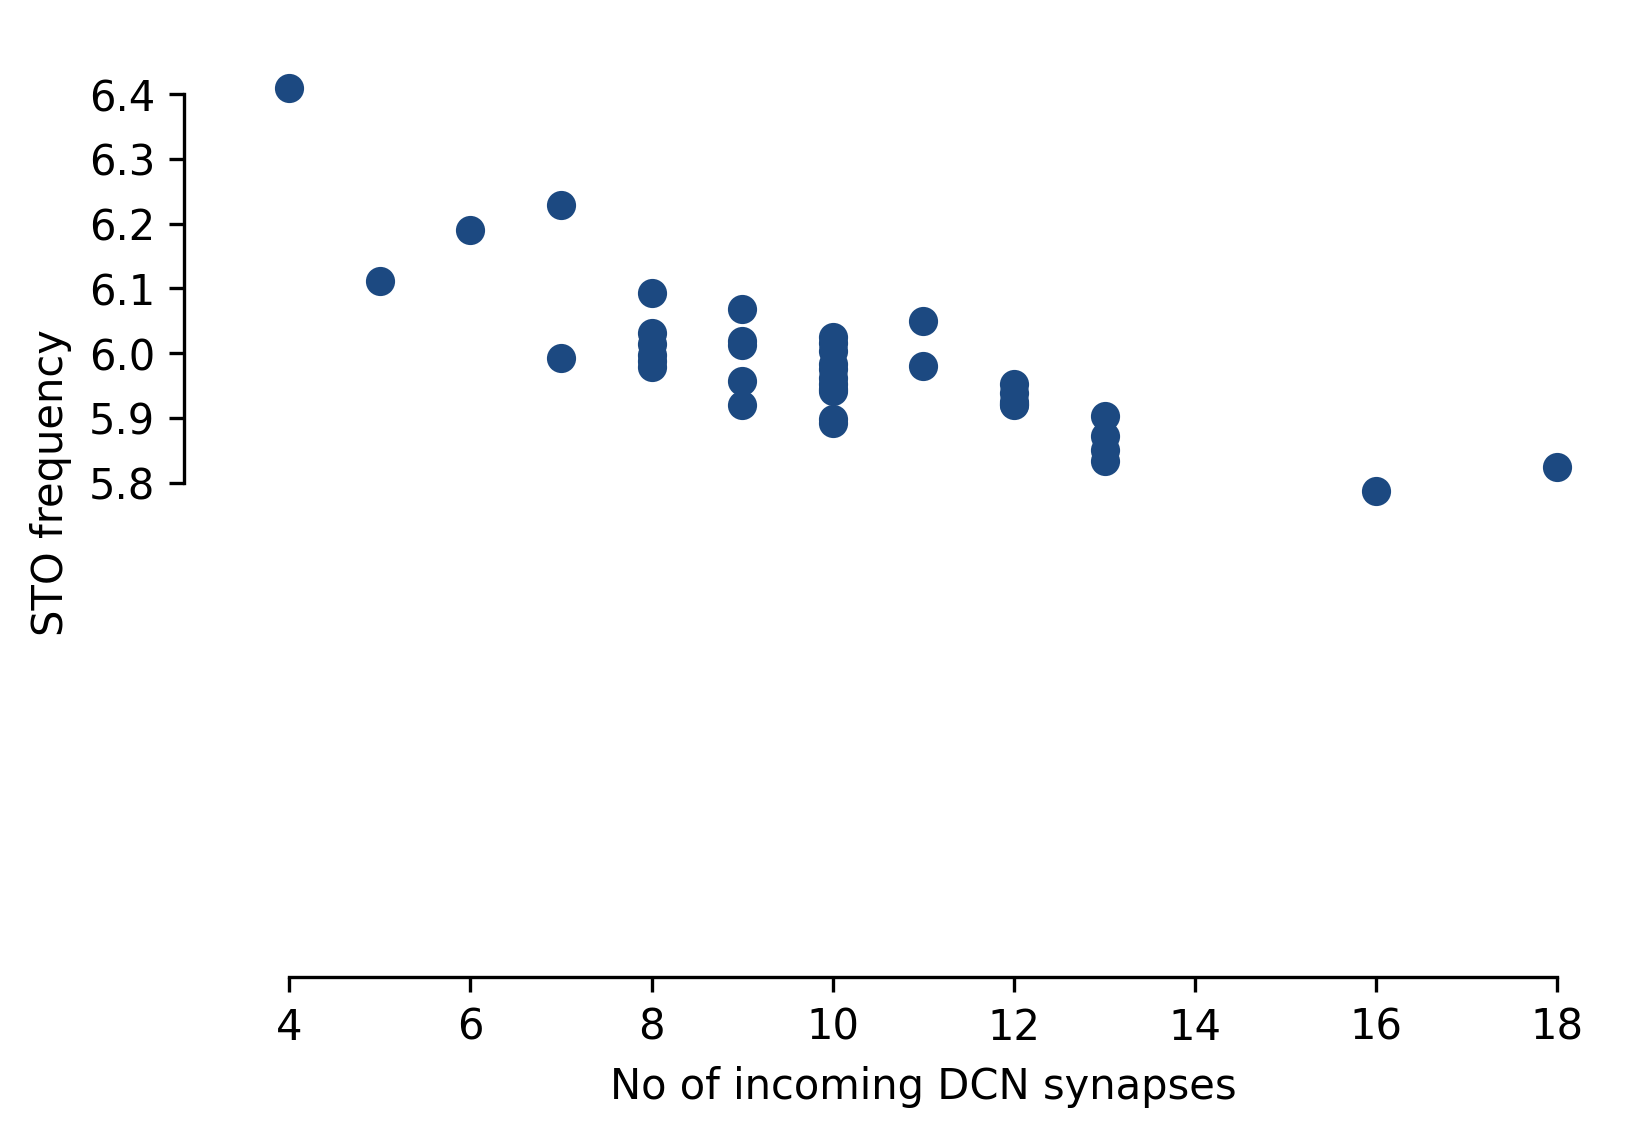

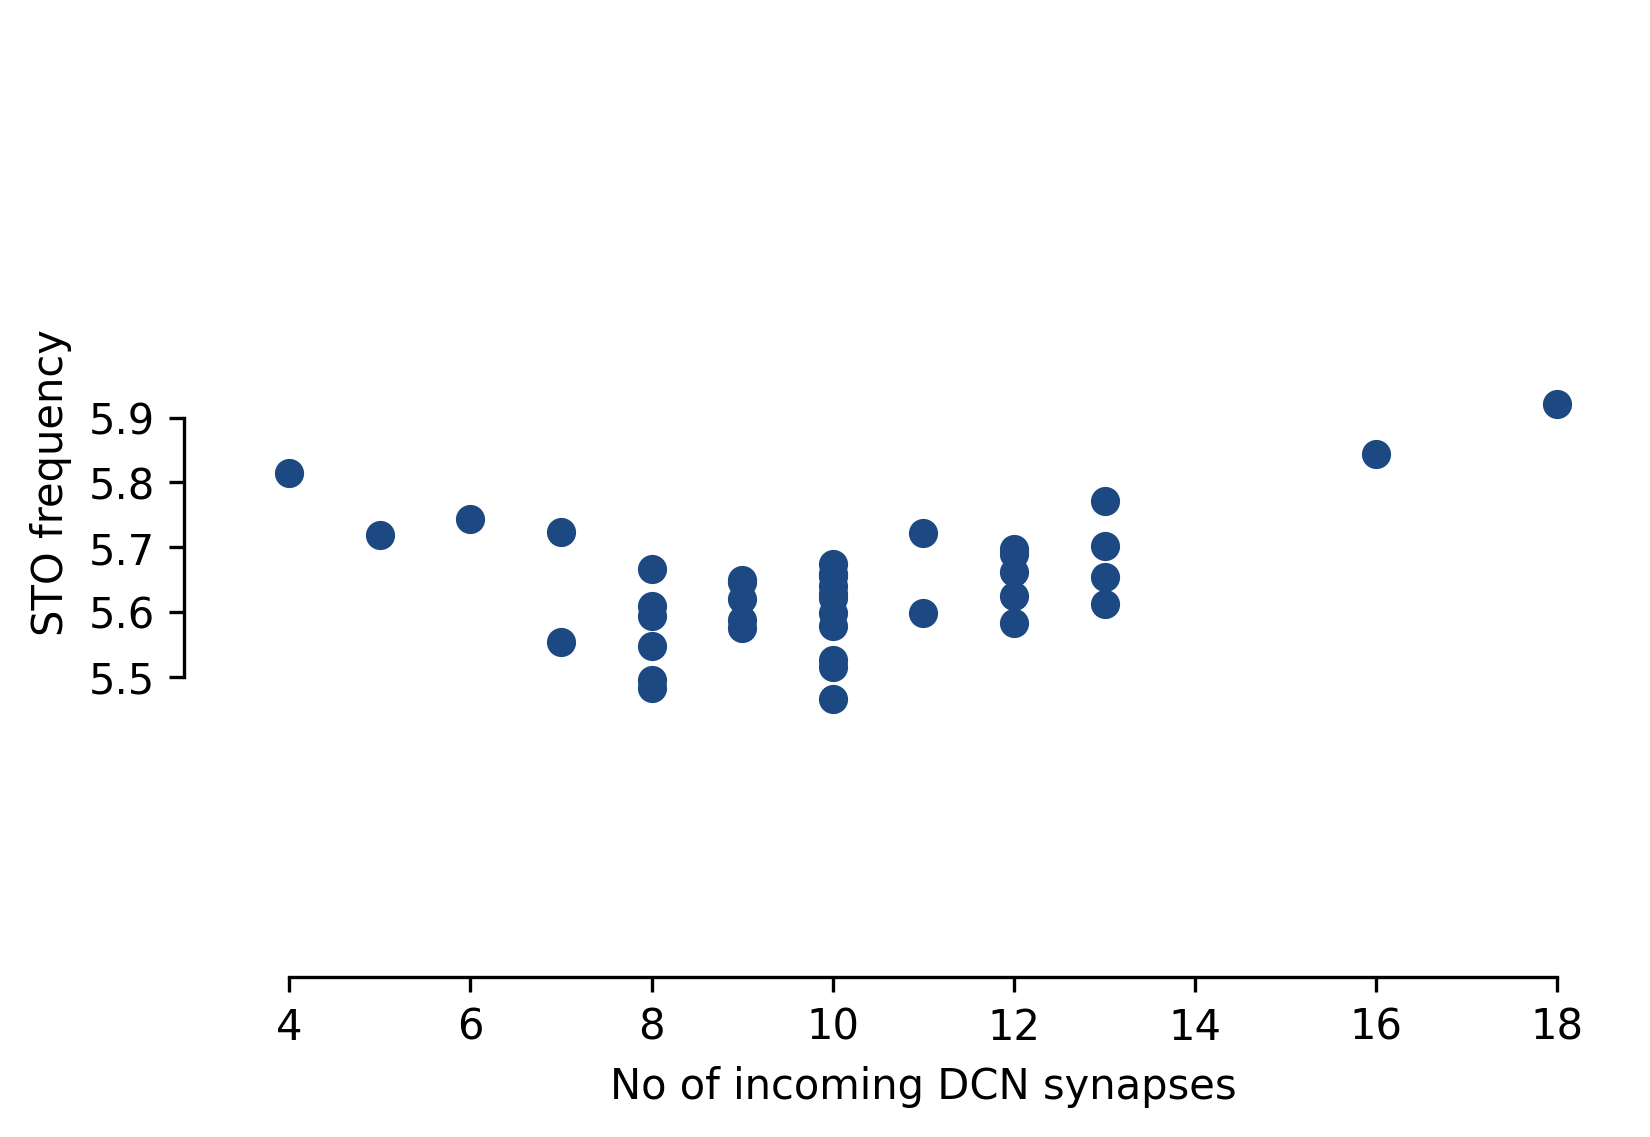

In [18]:
%%time
colors = dict(positive='#1c4981',negative='#8a1218')
color=colors['negative']

case = CN.before
fsto = get_sto_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fsto,color=color)
sns.despine(trim=True,offset=10)
ylim(5.1,6.5)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('STO frequency')
plt.savefig(f'CN_STO_coupled_neg_NP.svg')

case = UN.before
fsto = get_sto_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fsto,color=color)
sns.despine(trim=True,offset=10)
ylim(5.1,6.5)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('STO frequency')
plt.savefig(f'CN_STO_uncoupled_neg_NP.svg')

color=colors['positive']

case = CP.before
fsto = get_sto_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fsto,color=color)
sns.despine(trim=True,offset=10)
ylim(5.1,6.5)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('STO frequency')
plt.savefig(f'CN_STO_coupled_pos_NP.svg')

case = UP.before
fsto = get_sto_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fsto,color=color)
sns.despine(trim=True,offset=10)
ylim(5.1,6.5)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('STO frequency')
plt.savefig(f'CN_STO_uncoupled_pos_NP.svg')

CPU times: user 336 ms, sys: 301 ms, total: 637 ms
Wall time: 223 ms


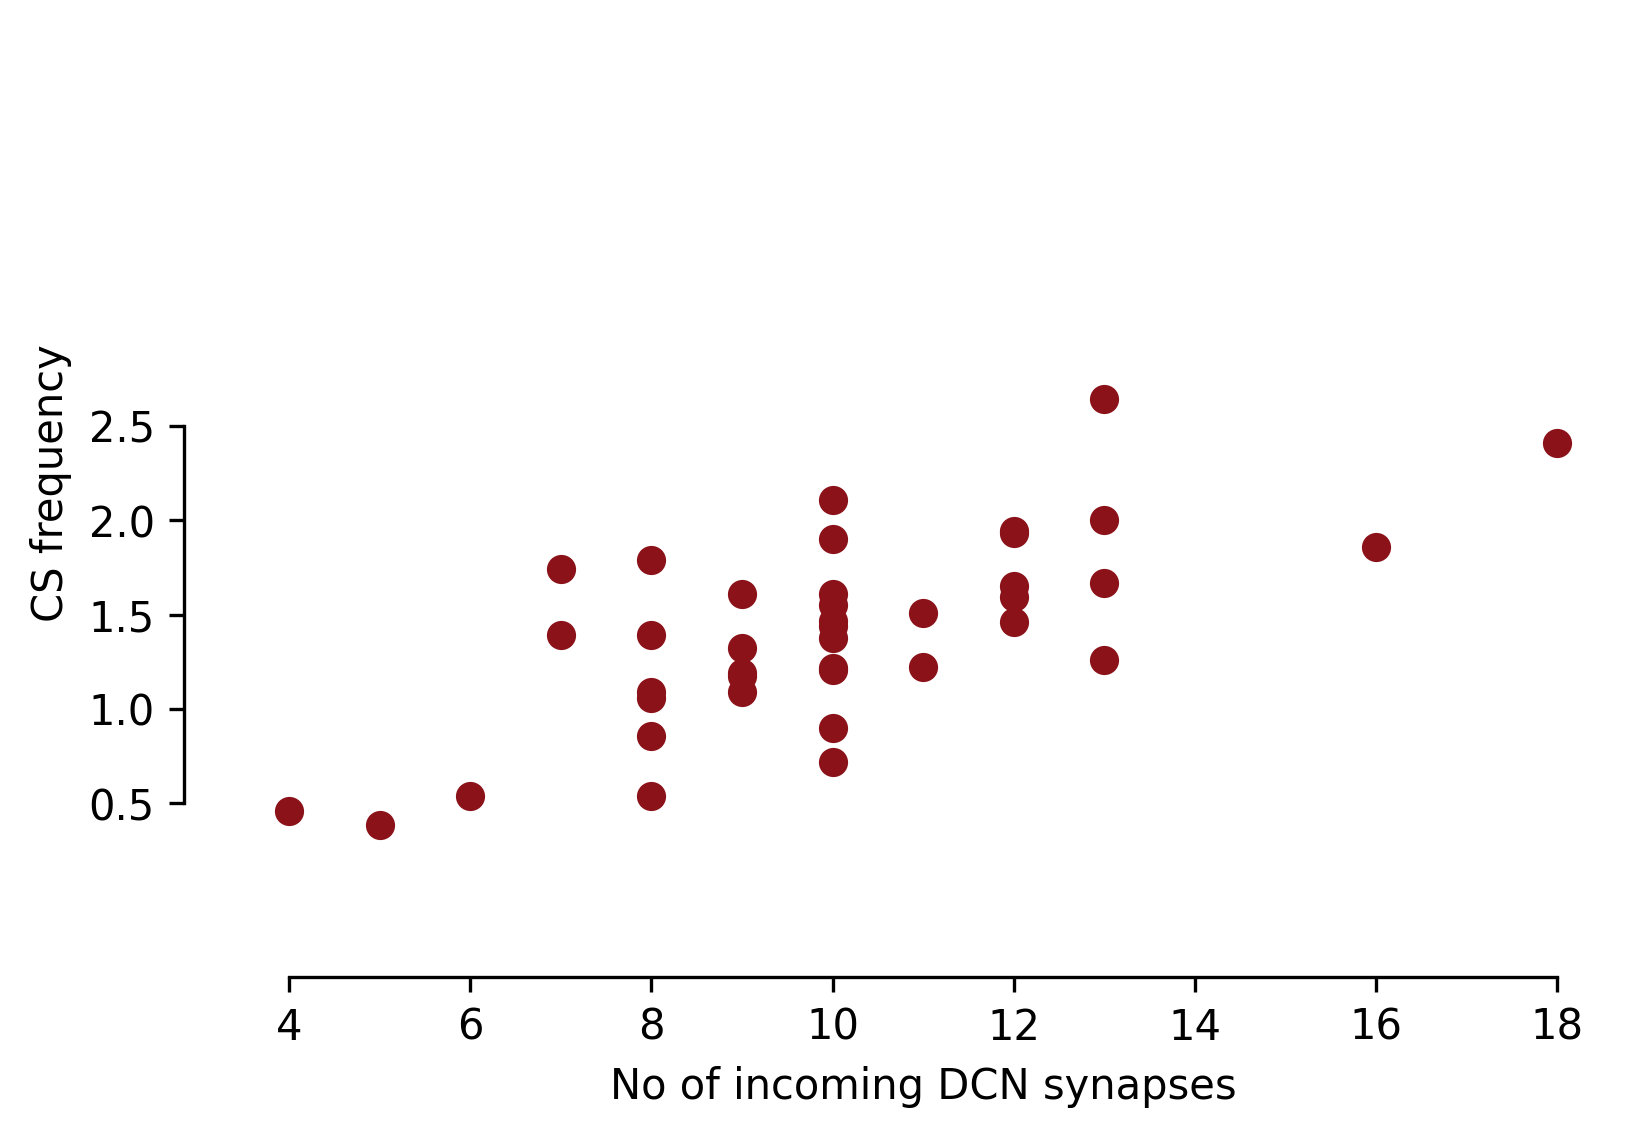

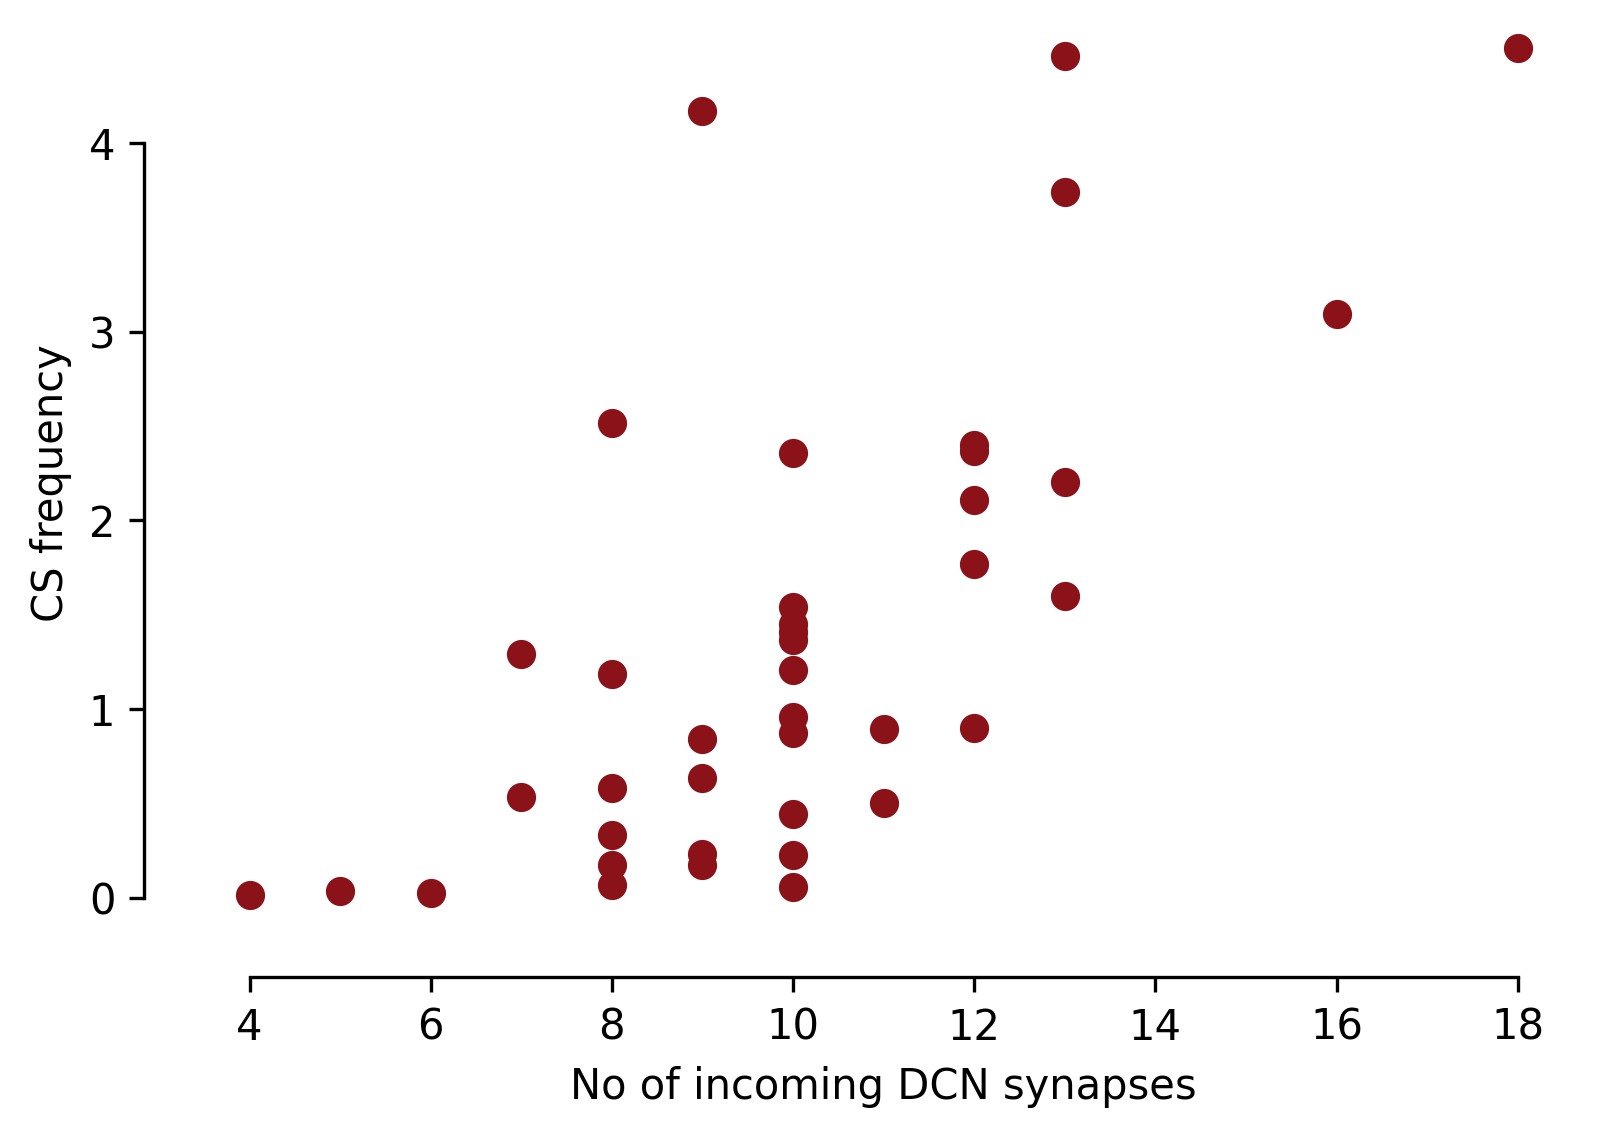

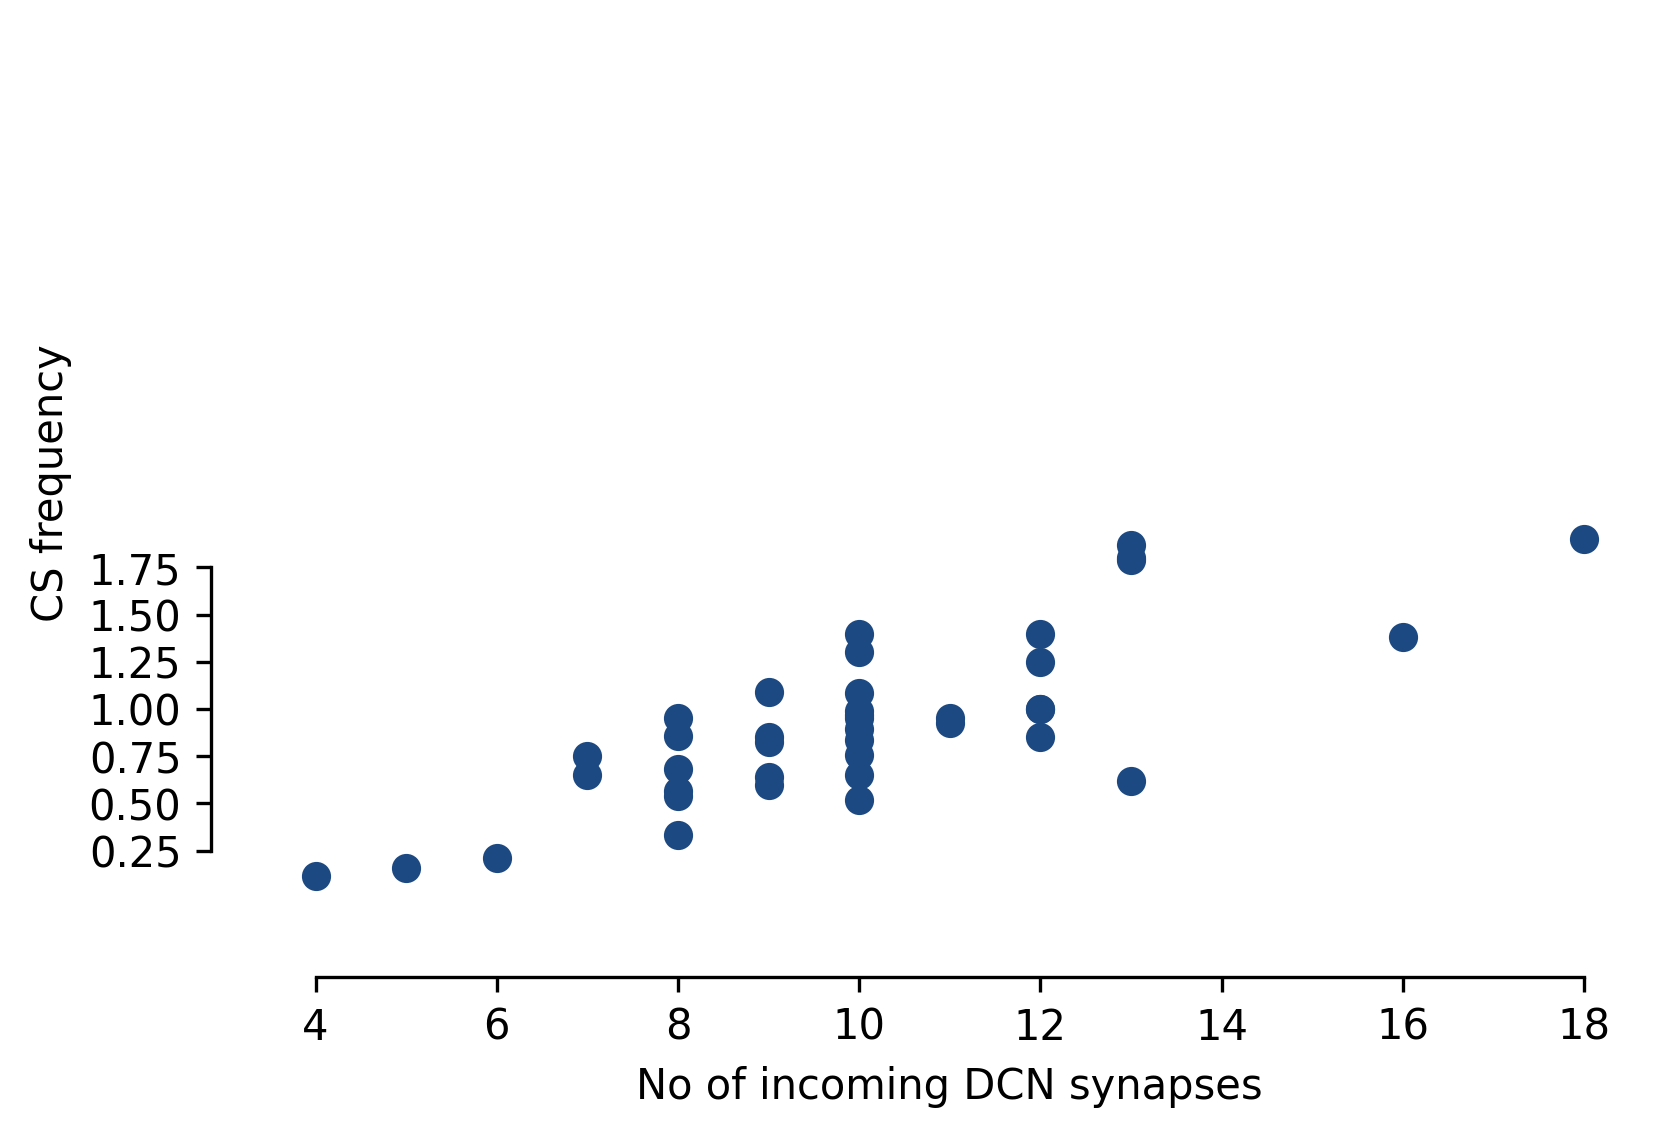

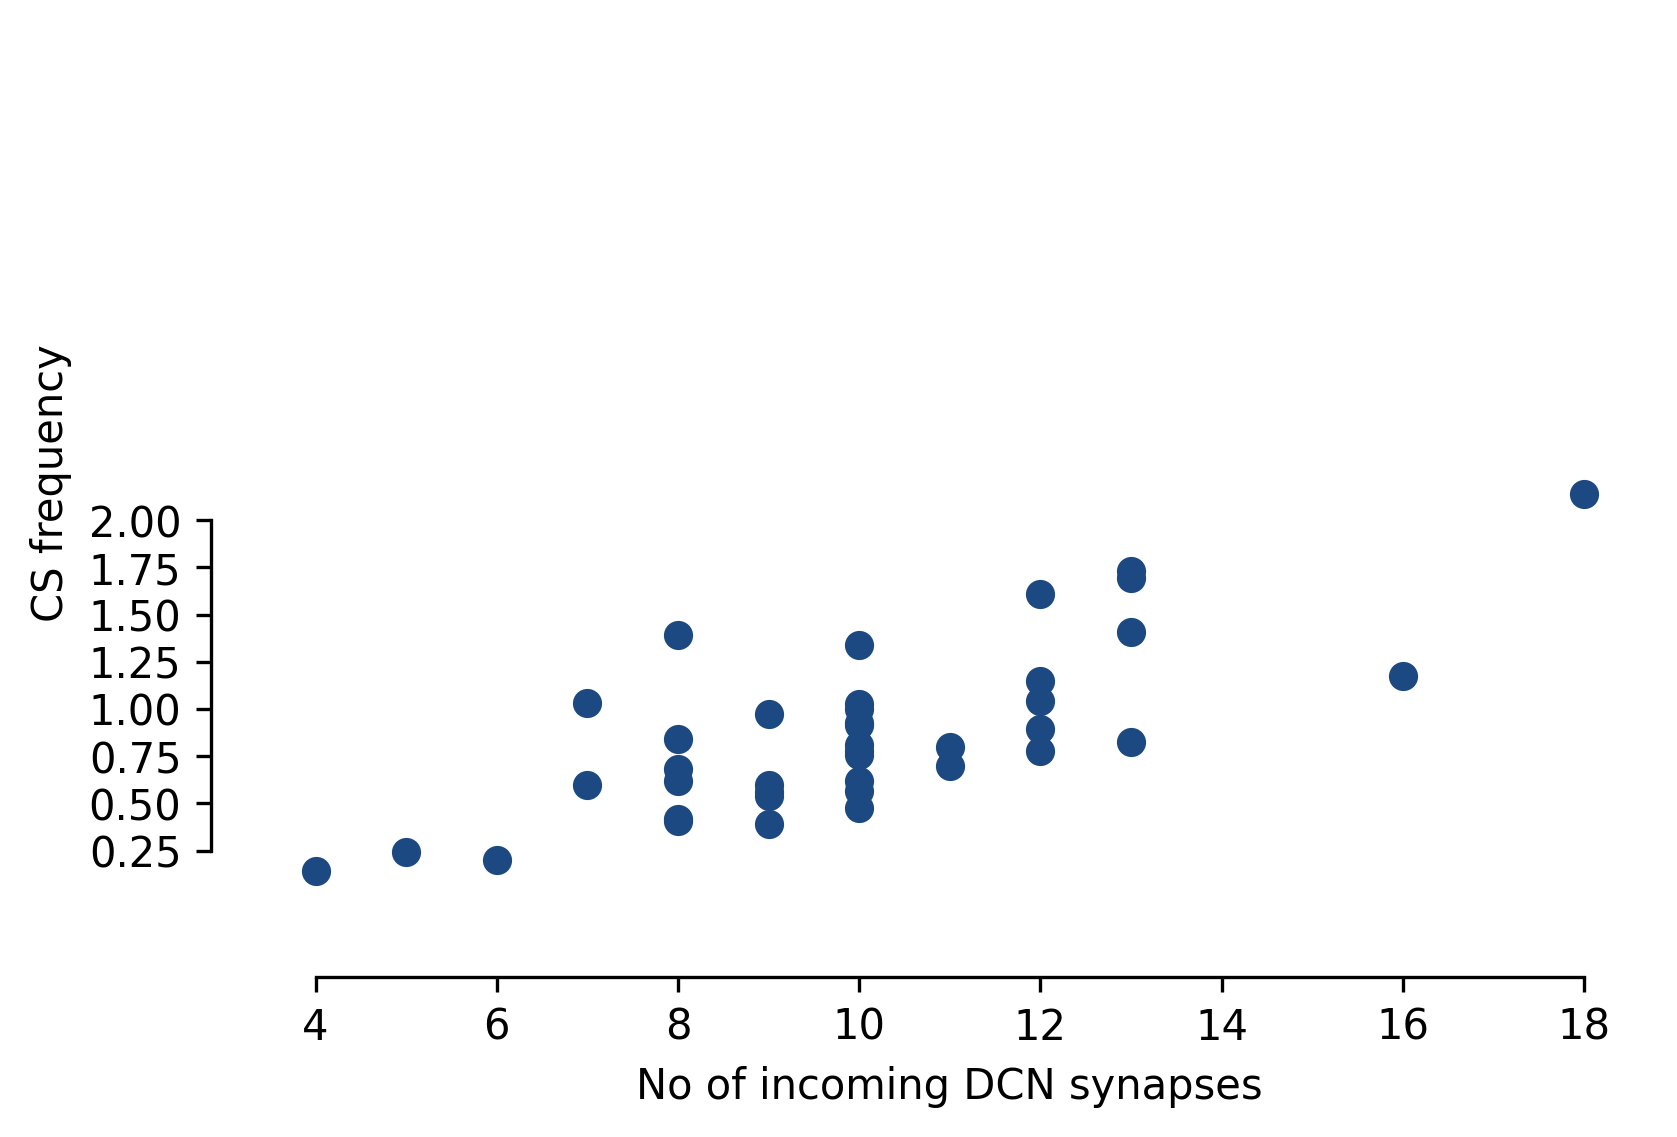

In [19]:
%%time
colors = dict(positive='#1c4981',negative='#8a1218')
color=colors['negative']

case = CN.before
fcs = get_cs_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fcs,color=color)
sns.despine(trim=True,offset=10)
ylim(-0.2,4.6)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('CS frequency')
plt.savefig(f'CN_CS_coupled_neg_NP.svg')

case = UN.before
fcs = get_cs_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fcs,color=color)
sns.despine(trim=True,offset=10)
ylim(-0.2,4.6)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('CS frequency')
plt.savefig(f'CN_CS_uncoupled_neg_NP.svg')

color=colors['positive']

case = CP.before
fcs = get_cs_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fcs,color=color)
sns.despine(trim=True,offset=10)
ylim(-0.2,4.6)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('CS frequency')
plt.savefig(f'CN_CS_coupled_pos_NP.svg')

case = UP.before
fcs = get_cs_freq(case, 0, 1)
ndcn = np.array(list(map(len, io_to_dcn)))
figure(dpi=300)
plt.scatter(ndcn, fcs,color=color)
sns.despine(trim=True,offset=10)
ylim(-0.2,4.6)
plt.xlabel('No of incoming DCN synapses')
plt.ylabel('CS frequency')
plt.savefig(f'CN_CS_uncoupled_pos_NP.svg')

